In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
import os
import matplotlib.gridspec as gridspec

import fit_time_dep_fluxes as fit_flux
from importlib import reload
reload(fit_flux)

import matplotlib
#matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)


In [2]:
plotpath = './figures/'
if not os.path.isdir(plotpath):
    os.makedirs(plotpath)


In [3]:
#generate some synthetic data

np.random.seed(101)

n_reads = 42
n_pixels = 100

#define true fluxes in each pixel
true_fluxes = ((np.random.rand(n_pixels)-0.5)*2)*200 + 1000 #high flux case
# true_fluxes = ((np.random.rand(n_pixels)-0.5)*2)*50 + 100 #moderate flux cas
# true_fluxes = ((np.random.rand(n_pixels)-0.5)*2)*2 + 5 #low flux case

#set the read noise in each pixel
read_errs = ((np.random.rand(n_pixels)-0.5)*2)*5 + 28

#define the true multiplicative factor to the fluxes
true_b_vect = np.ones(n_reads-1)*1.0
true_b_vect = np.linspace(0.5,2.0,n_reads-1)
true_b_vect[n_reads//2:] = 1.0
true_b_vect /= true_b_vect.max()

true_b_vect = 1.0 - (np.random.rand(n_reads-1))*0.5

read_times = np.arange(n_reads)
read_diff_times = 0.5*(read_times[1:]+read_times[:-1])

obs_fluxes = fit_flux.generate_data(read_errs,true_fluxes,true_b_vect)

obs_fluxes_errs = np.sqrt(np.power(read_errs,2)+np.maximum(true_fluxes,0))
obs_flux_diffs = np.diff(obs_fluxes,axis=1)
# obs_flux_diff_errs = np.sqrt((read_err*2)**2+np.maximum(true_fluxes[:,1:],0))
obs_flux_diff_errs = np.sqrt(np.power(read_errs*2,2)[:,None]+np.maximum(obs_flux_diffs,0))


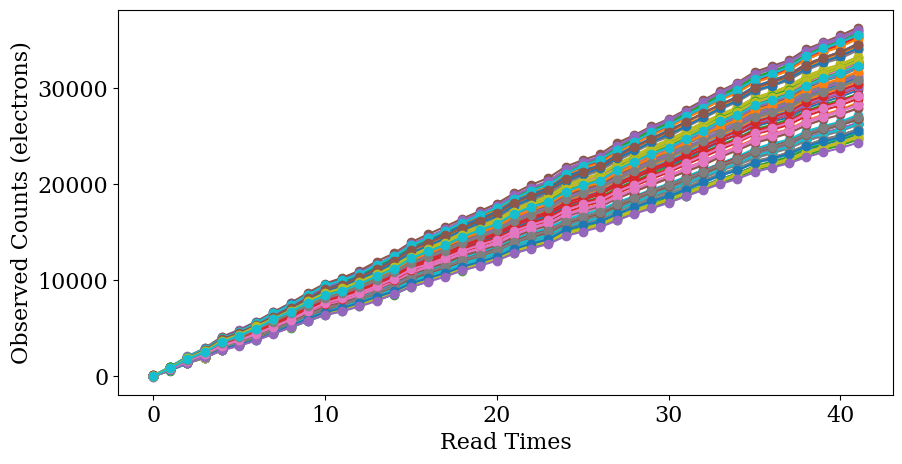

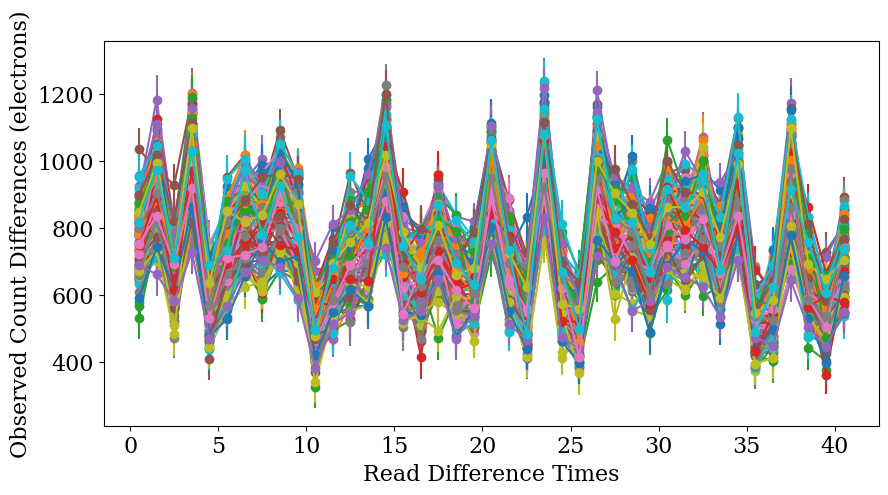

In [4]:

plt.figure(figsize=(10,5))
for j in range(n_pixels):
    plt.errorbar(read_times,obs_fluxes[j],yerr=obs_fluxes_errs[j],fmt='-o')
plt.xlabel('Read Times')
plt.ylabel('Observed Counts (electrons)')
plt.show()

plt.figure(figsize=(10,5))
for j in range(n_pixels):
    plt.errorbar(read_diff_times,obs_flux_diffs[j],yerr=obs_flux_diff_errs[j],fmt='-o')
plt.xlabel('Read Difference Times')
plt.ylabel('Observed Count Differences (electrons)')
plt.show()


In [5]:
np.shape(read_errs),np.shape(obs_fluxes)

((100,), (100, 42))

In [6]:
max_b_ind,b_vect_mean,b_vect_Vinv,b_vect_V,\
        f_max_means_given_b,f_max_ivars_given_b,\
        comb_param_means,comb_param_Vinv,comb_param_V,comb_param_samps = fit_flux.measure_time_dep_fluxes_GIBBS(obs_fluxes,read_errs,
                                                       n_samples=10000,b_vect_change_tol=1e-10,
                                                       min_b_val=1e-10,min_f_val=1e-10,
                                                       rescale=True,true_b_vect=true_b_vect,
                                                       true_fluxes=true_fluxes,
                                                       use_linear_first_guess=True,
                                                       verbose=True,return_samples=True)

f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=None)
f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=b_vect_mean)

non_max_inds = np.ones(len(b_vect_mean)).astype(bool)
non_max_inds[max_b_ind] = False
non_max_inds = np.where(non_max_inds)[0]

b_vect_errs = np.sqrt(np.diag(b_vect_V))
f_max_errs_given_b = np.power(f_max_ivars_given_b,-0.5)

b_vect_mean_gibbs = np.copy(b_vect_mean)
b_vect_errs_gibbs = np.copy(b_vect_errs)
b_vect_cov_gibbs = np.copy(b_vect_V)
comb_param_samps_gibbs = np.copy(comb_param_samps)

comb_param_mean_gibbs = np.copy(comb_param_means)
comb_param_V_gibbs = np.copy(comb_param_V)

Using Gibbs sampling to generate 10000 samples


100%|██████████| 10000/10000 [01:20<00:00, 123.94it/s]

Done


In [7]:
max_b_ind,b_vect_mean,b_vect_Vinv,b_vect_V,\
        f_max_means_given_b,f_max_ivars_given_b,\
        comb_param_means,comb_param_Vinv,comb_param_V = fit_flux.measure_time_dep_fluxes_LINEAR(obs_fluxes,read_errs,
                                                       n_max_repeat=1000,b_vect_change_tol=1e-10,
                                                       min_b_val=1e-10,min_f_val=1e-10,
                                                       rescale=True,true_b_vect=true_b_vect,
                                                       true_fluxes=true_fluxes)

f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=None)
f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=b_vect_mean)

non_max_inds = np.ones(len(b_vect_mean)).astype(bool)
non_max_inds[max_b_ind] = False
non_max_inds = np.where(non_max_inds)[0]

b_vect_errs = np.sqrt(np.diag(b_vect_V))
f_max_errs_given_b = np.power(f_max_ivars_given_b,-0.5)

b_vect_mean_linear = np.copy(b_vect_mean)
b_vect_errs_linear = np.copy(b_vect_errs)
b_vect_cov_linear = np.copy(b_vect_V)

#draw samples from the linearized-method
n_samples = 10000
curr_L = np.linalg.cholesky(comb_param_V)
comb_param_samps = np.einsum('ij,nj->ni',curr_L,np.random.randn(n_samples,len(comb_param_means)))+comb_param_means
comb_param_samps_linear = np.copy(comb_param_samps)

comb_param_mean_linear = np.copy(comb_param_means)
comb_param_V_linear = np.copy(comb_param_V)

In [8]:
true_param_means = np.zeros_like(comb_param_means)
true_param_means[:n_pixels] = true_fluxes
true_param_means[n_pixels:] = true_b_vect[non_max_inds]

diff = (comb_param_means-true_param_means)
full_chi2 = np.dot(np.dot(diff,comb_param_Vinv),diff)
indv_chi2 = np.sum((np.power(diff,2)/(np.diag(comb_param_V))))

print(full_chi2/len(diff),indv_chi2/len(diff),len(diff))

0.9935154995869437 0.5773009675410027 140


In [9]:
diff = (comb_param_means-true_param_means)[:n_pixels]
full_chi2 = np.dot(np.dot(diff,comb_param_Vinv[:n_pixels,:n_pixels]),diff)
indv_chi2 = np.sum((np.power(diff,2)/(np.diag(comb_param_V)[:n_pixels])))

print(full_chi2/len(diff),indv_chi2/len(diff),len(diff))

diff = (f_max_means_given_b-true_fluxes)
indv_chi2 = np.sum((np.power(diff/f_max_errs_given_b,2)))

print(indv_chi2/len(diff),len(diff))


1.02956026600597 0.5956380525417205 100
1.0337859206349542 100


In [10]:
diff = (comb_param_means-true_param_means)[n_pixels:]
full_chi2 = np.dot(np.dot(diff,comb_param_Vinv[n_pixels:,n_pixels:]),diff)
indv_chi2 = np.sum((np.power(diff,2)/(np.diag(comb_param_V)[n_pixels:])))

print(full_chi2/len(diff),indv_chi2/len(diff),len(diff))

diff = (b_vect_mean-true_b_vect)[non_max_inds]
full_chi2 = np.dot(np.dot(diff,b_vect_Vinv[non_max_inds][:,non_max_inds]),diff)
indv_chi2 = np.sum((np.power(diff,2)/(np.diag(b_vect_V)[non_max_inds])))

print(full_chi2/len(diff),indv_chi2/len(diff),len(diff))


0.9041322537900071 0.531458255039208 40
0.9041322537900071 0.531458255039208 40


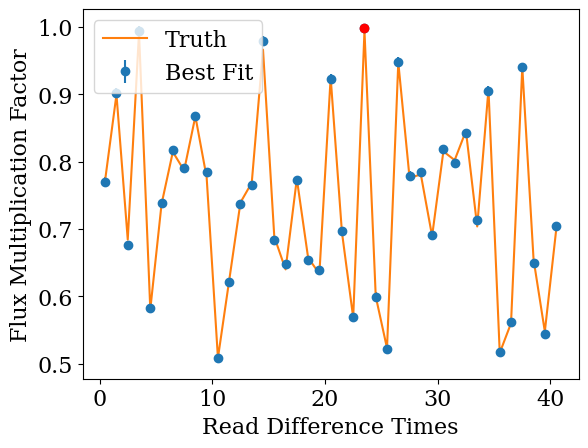

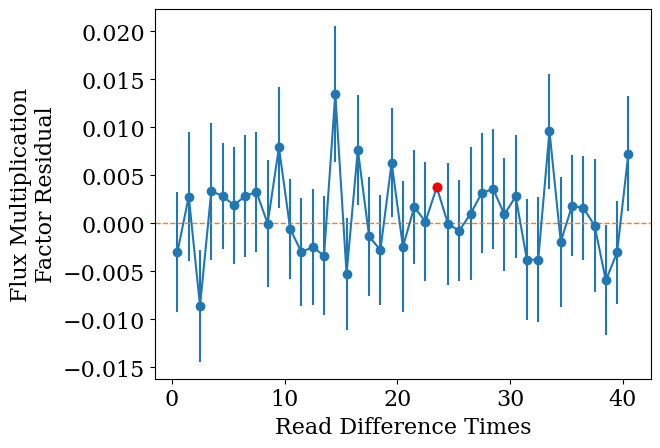

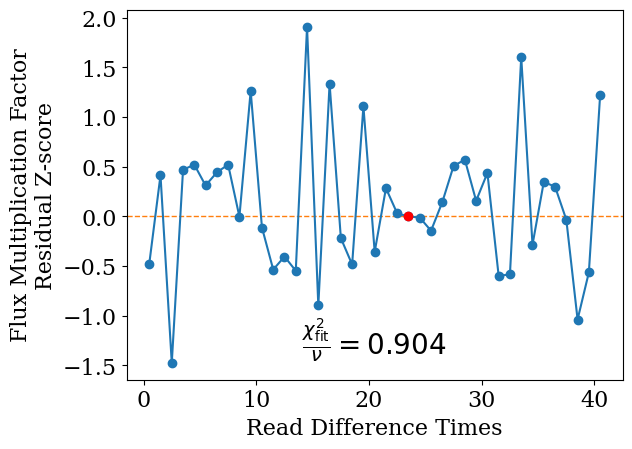

In [11]:
diff = (b_vect_mean-true_b_vect)[non_max_inds]
full_chi2 = np.dot(np.dot(diff,b_vect_Vinv[non_max_inds][:,non_max_inds]),diff)

b_vect_fit_scaled_chi2 = full_chi2/len(diff)
chi2_label = r'$\frac{\chi_{\mathrm{fit}}^2}{\nu} = %.3f$'%b_vect_fit_scaled_chi2

plt.errorbar(read_diff_times,b_vect_mean,yerr=b_vect_errs,fmt='o',label='Best Fit')
plt.errorbar(read_diff_times[max_b_ind],b_vect_mean[max_b_ind],
             yerr=b_vect_errs[max_b_ind],
             fmt='o',color='r')
plt.plot(read_diff_times,true_b_vect,label='Truth')
plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication Factor')
leg = plt.legend(loc='best')
plt.show()

plt.errorbar(read_diff_times,b_vect_mean-true_b_vect,yerr=b_vect_errs,fmt='-o')
plt.errorbar(read_diff_times[max_b_ind],(b_vect_mean-true_b_vect)[max_b_ind],
             yerr=b_vect_errs[max_b_ind],
             fmt='-o',color='r')
plt.axhline(0,c='C1',ls='--',lw=1)
plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication\nFactor Residual')
plt.show()

z_scores = (b_vect_mean-true_b_vect)/b_vect_errs
plt.errorbar(read_diff_times,z_scores,fmt='-o')
plt.errorbar(read_diff_times[max_b_ind],z_scores[max_b_ind],
             fmt='-o',color='r')
plt.text(np.mean(read_diff_times),np.min(z_scores),
         chi2_label,va='bottom',ha='center',fontsize=20)
plt.axhline(0,c='C1',ls='--',lw=1)
plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication Factor\nResidual Z-score')
plt.show()


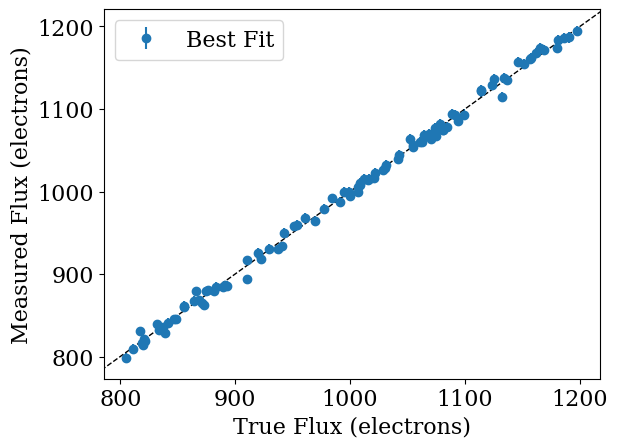

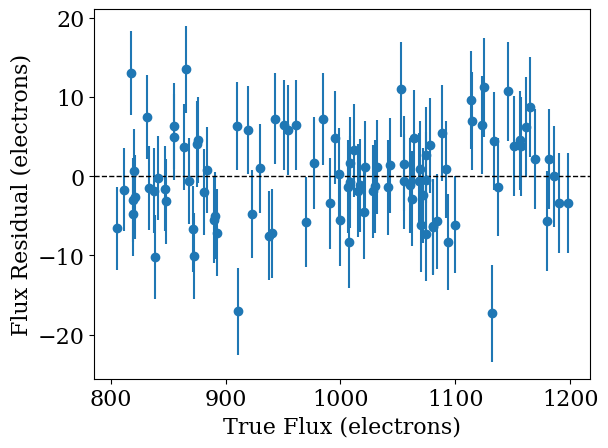

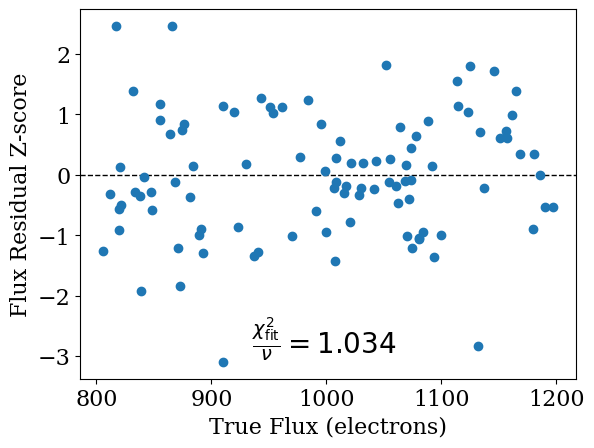

In [56]:
diff = (f_means_with_b-true_fluxes)
indv_chi2 = np.sum((np.power(diff/np.sqrt(1/f_ivars_with_b),2)))

fluxes_fit_scaled_chi2 = indv_chi2/len(diff)
chi2_label = r'$\frac{\chi_{\mathrm{fit}}^2}{\nu} = %.3f$'%fluxes_fit_scaled_chi2



pixel_inds = np.arange(n_pixels)

# plt.errorbar(true_fluxes,f_max_means_given_b,yerr=np.sqrt(1/f_max_ivars_given_b),fmt='o',label='Best Fit')
plt.errorbar(true_fluxes,f_means_with_b,yerr=np.sqrt(1/f_ivars_with_b),fmt='o',label=r'Best Fit')
# plt.errorbar(true_fluxes,f_means_with_b,yerr=np.sqrt(1/f_ivars_with_b),fmt='o',label=r'Best Fit, with $\vec b$')
# plt.errorbar(true_fluxes,f_means_no_b,yerr=np.sqrt(1/f_ivars_no_b),fmt='o',label=r'Best Fit, no $\vec b$')
plt.xlabel('True Flux (electrons)')
plt.ylabel('Measured Flux (electrons)')
leg = plt.legend(loc='best')
xlim = plt.xlim()
ylim = plt.ylim()
line_xy = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
plt.plot(line_xy,line_xy,c='k',ls='--',lw=1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

# plt.errorbar(true_fluxes,f_max_means_given_b-true_fluxes,yerr=np.sqrt(1/f_max_ivars_given_b),fmt='o')
plt.errorbar(true_fluxes,f_means_with_b-true_fluxes,yerr=np.sqrt(1/f_ivars_with_b),fmt='o')
plt.axhline(0,c='k',ls='--',lw=1)
plt.xlabel('True Flux (electrons)')
plt.ylabel('Flux Residual (electrons)')
plt.show()

zscores = (f_means_with_b-true_fluxes)*np.sqrt(f_ivars_with_b)
# plt.errorbar(true_fluxes,(f_max_means_given_b-true_fluxes)*np.sqrt(f_max_ivars_given_b),fmt='o')
plt.errorbar(true_fluxes,zscores,fmt='o')
plt.text(np.mean(true_fluxes),np.min(zscores),
         chi2_label,va='bottom',ha='center',fontsize=20)
plt.axhline(0,c='k',ls='--',lw=1)
plt.xlabel('True Flux (electrons)')
plt.ylabel('Flux Residual Z-score')
plt.show()


array([34.18525998, 34.68786713, 27.54271705, 29.39106453, 36.62104772,
       38.35362057, 31.00161898, 39.02657096, 37.28238695, 29.86484416,
       34.79249976, 31.93306851, 29.47243252, 37.85252976, 40.32767785,
       30.24252212, 28.20038541, 35.413707  , 37.11752044, 30.3173597 ,
       36.27869268, 33.98571025, 27.93694461, 29.24897114, 29.85235435,
       40.24592273, 34.00296217, 35.06835427, 36.67604702, 34.51040714,
       39.58081162, 38.11486853, 32.67359959, 32.52667308, 39.69474346,
       31.60770724, 39.127051  , 37.46359928, 34.57085861, 39.34208362,
       28.28624776, 28.42205173, 36.48345646, 39.45042852, 29.62255403,
       31.01606338, 36.46085522, 29.94513041, 36.2837041 , 34.10540286,
       36.076075  , 34.40573875, 28.05269694, 30.27720586, 34.73547315,
       28.8095225 , 33.96154247, 29.53412643, 27.6593684 , 29.66202199,
       33.20417417, 39.29576359, 39.7015256 , 33.36943028, 33.71012904,
       35.67780908, 31.68027318, 28.79044091, 27.82342942, 35.91

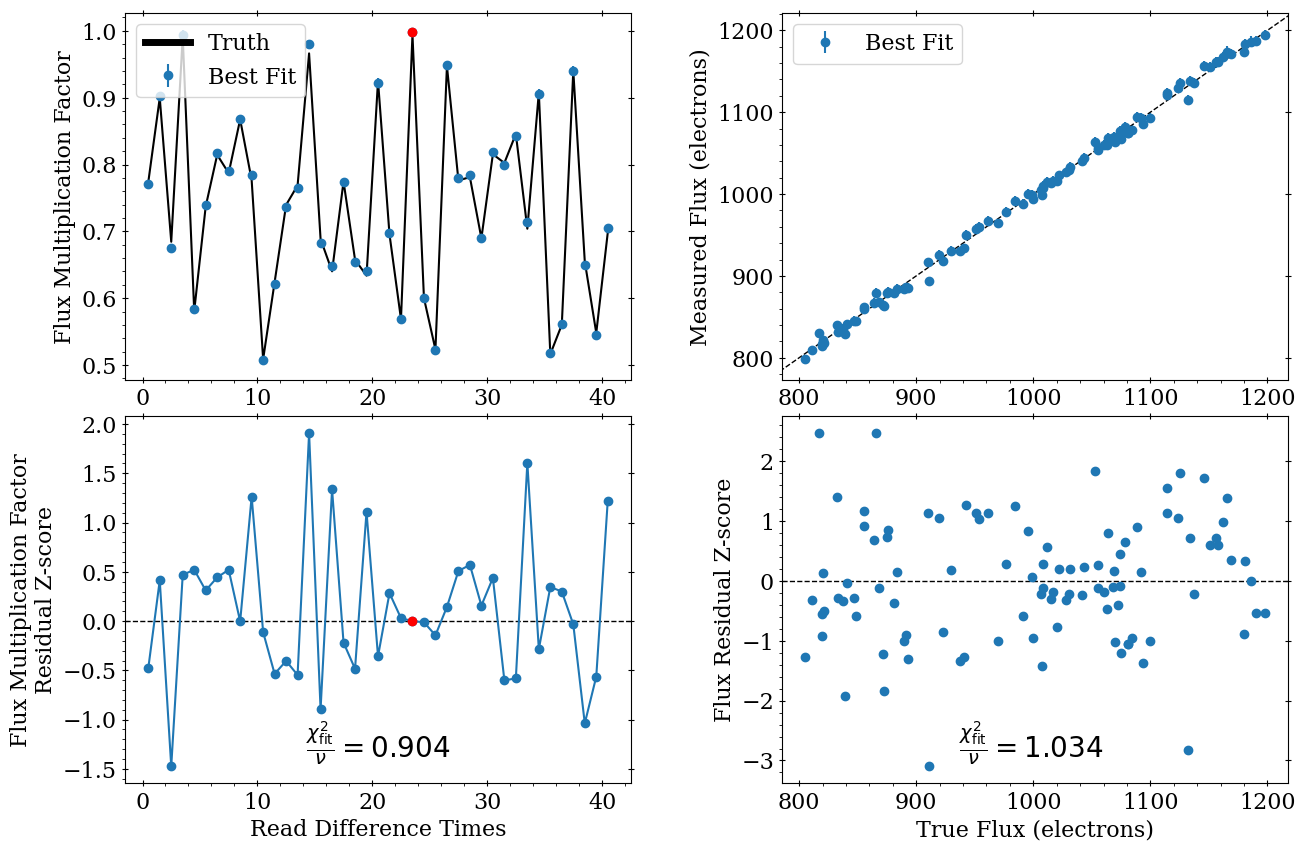

In [13]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2,wspace=0.3,hspace=0.1)
ax = plt.subplot(gs[0,0])    
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

diff = (b_vect_mean-true_b_vect)[non_max_inds]
full_chi2 = np.dot(np.dot(diff,b_vect_Vinv[non_max_inds][:,non_max_inds]),diff)

b_vect_fit_scaled_chi2 = full_chi2/len(diff)
chi2_label = r'$\frac{\chi_{\mathrm{fit}}^2}{\nu} = %.3f$'%b_vect_fit_scaled_chi2

plt.errorbar(read_diff_times,b_vect_mean,yerr=b_vect_errs,fmt='o',label='Best Fit')
plt.errorbar(read_diff_times[max_b_ind],b_vect_mean[max_b_ind],
             yerr=b_vect_errs[max_b_ind],
             fmt='o',color='r')
plt.plot(read_diff_times,true_b_vect,label='Truth',c='k')
# plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication Factor')
leg = plt.legend(loc='best')
for line in leg.get_lines():
    line.set_linewidth(5)



ax = plt.subplot(gs[1,0])    
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

z_scores = (b_vect_mean-true_b_vect)/b_vect_errs
plt.errorbar(read_diff_times,z_scores,fmt='-o')
plt.errorbar(read_diff_times[max_b_ind],z_scores[max_b_ind],
             fmt='-o',color='r')
plt.text(np.mean(read_diff_times),np.min(z_scores),
         chi2_label,va='bottom',ha='center',fontsize=20)
plt.axhline(0,c='k',ls='--',lw=1)
plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication Factor\nResidual Z-score')

ax = plt.subplot(gs[0,1])    
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

diff = (f_means_with_b-true_fluxes)
indv_chi2 = np.sum((np.power(diff/np.sqrt(1/f_ivars_with_b),2)))

fluxes_fit_scaled_chi2 = indv_chi2/len(diff)
chi2_label = r'$\frac{\chi_{\mathrm{fit}}^2}{\nu} = %.3f$'%fluxes_fit_scaled_chi2

pixel_inds = np.arange(n_pixels)

# plt.errorbar(true_fluxes,f_max_means_given_b,yerr=np.sqrt(1/f_max_ivars_given_b),fmt='o',label='Best Fit')
plt.errorbar(true_fluxes,f_means_with_b,yerr=np.sqrt(1/f_ivars_with_b),fmt='o',label=r'Best Fit')
# plt.errorbar(true_fluxes,f_means_with_b,yerr=np.sqrt(1/f_ivars_with_b),fmt='o',label=r'Best Fit, with $\vec b$')
# plt.errorbar(true_fluxes,f_means_no_b,yerr=np.sqrt(1/f_ivars_no_b),fmt='o',label=r'Best Fit, no $\vec b$')
# plt.xlabel('True Flux (electrons)')
plt.ylabel('Measured Flux (electrons)')
leg = plt.legend(loc='best')
xlim = plt.xlim()
ylim = plt.ylim()
line_xy = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
plt.plot(line_xy,line_xy,c='k',ls='--',lw=1)
plt.xlim(xlim)
plt.ylim(ylim)

ax = plt.subplot(gs[1,1])    
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)


zscores = (f_means_with_b-true_fluxes)*np.sqrt(f_ivars_with_b)
# plt.errorbar(true_fluxes,(f_max_means_given_b-true_fluxes)*np.sqrt(f_max_ivars_given_b),fmt='o')
plt.errorbar(true_fluxes,zscores,fmt='o')
plt.text(np.mean(true_fluxes),np.min(zscores),
         chi2_label,va='bottom',ha='center',fontsize=20)
plt.axhline(0,c='k',ls='--',lw=1)
plt.xlabel('True Flux (electrons)')
plt.ylabel('Flux Residual Z-score')

plt.savefig(f'{plotpath}single_fit_output_comparison.png')
plt.show()


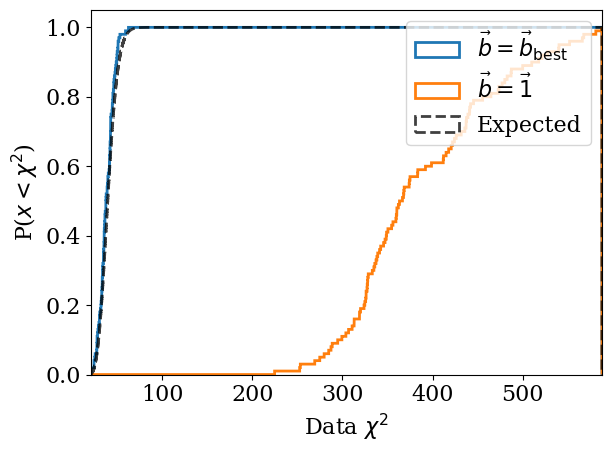

In [14]:
lw = 2
alpha = 1.0
cumulative = True

hist_range = [min(np.min(chi2s_data_with_b),np.min(chi2s_data_no_b)),\
              max(np.max(chi2s_data_with_b),np.max(chi2s_data_no_b))]

hist = plt.hist(chi2s_data_with_b,
         histtype='step',cumulative=cumulative,
         density=True,bins=10000,range=hist_range,
         label=r'$\vec b = \vec b_{\mathrm{best}}$',
         lw=lw,alpha=alpha)
hist_bins = hist[1]
hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])

plt.hist(chi2s_data_no_b,
         histtype='step',cumulative=cumulative,
         density=True,bins=10000,range=hist_range,
         label=r'$\vec b = \vec 1$',
         lw=lw,alpha=alpha)
expect_weights = np.diff(stats.chi2(loc=0,scale=1,df=n_reads-2).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc='best')
plt.xlim(hist_range[0],hist_range[1])
plt.xlabel('Data $\chi^2$')
plt.ylabel('P($x < \chi^2$)')
plt.tight_layout()
plt.savefig(f'{plotpath}single_fit_data_chi2.png')
plt.show()


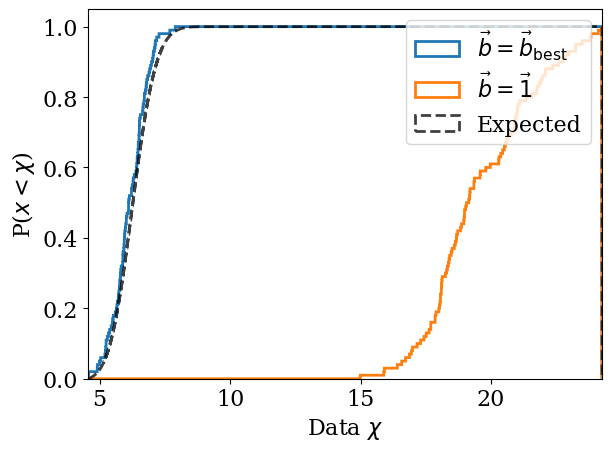

In [15]:
lw = 2
alpha = 1.0
cumulative = True

hist_range = [min(np.min(chi2s_data_with_b),np.min(chi2s_data_no_b)),\
              max(np.max(chi2s_data_with_b),np.max(chi2s_data_no_b))]
hist_range = np.sqrt(np.array(hist_range))

hist = plt.hist(np.sqrt(chi2s_data_with_b),
         histtype='step',cumulative=cumulative,
         density=True,bins=10000,range=hist_range,
         label=r'$\vec b = \vec b_{\mathrm{best}}$',
         lw=lw,alpha=alpha)
hist_bins = hist[1]
hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])

plt.hist(np.sqrt(chi2s_data_no_b),
         histtype='step',cumulative=cumulative,
         density=True,bins=10000,range=hist_range,
         label=r'$\vec b = \vec 1$',
         lw=lw,alpha=alpha)
expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_reads-2).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc='best')
plt.xlabel('Data $\chi$')
plt.ylabel('P($x < \chi$)')
plt.xlim(hist_range[0],hist_range[1])
plt.tight_layout()
plt.savefig(f'{plotpath}single_fit_data_chi.png')
plt.show()


In [16]:
def quad_form_grid(mean, cov, X, Y):
    """
    Compute Q(x) = (x - mean)^T cov^{-1} (x - mean) on a grid.
    """
    inv_cov = np.linalg.inv(cov)
    dx = X - mean[0]
    dy = Y - mean[1]
    D = np.stack([dx, dy], axis=-1)
    Q = np.einsum('...i,ij,...j->...', D, inv_cov, D)
    return Q


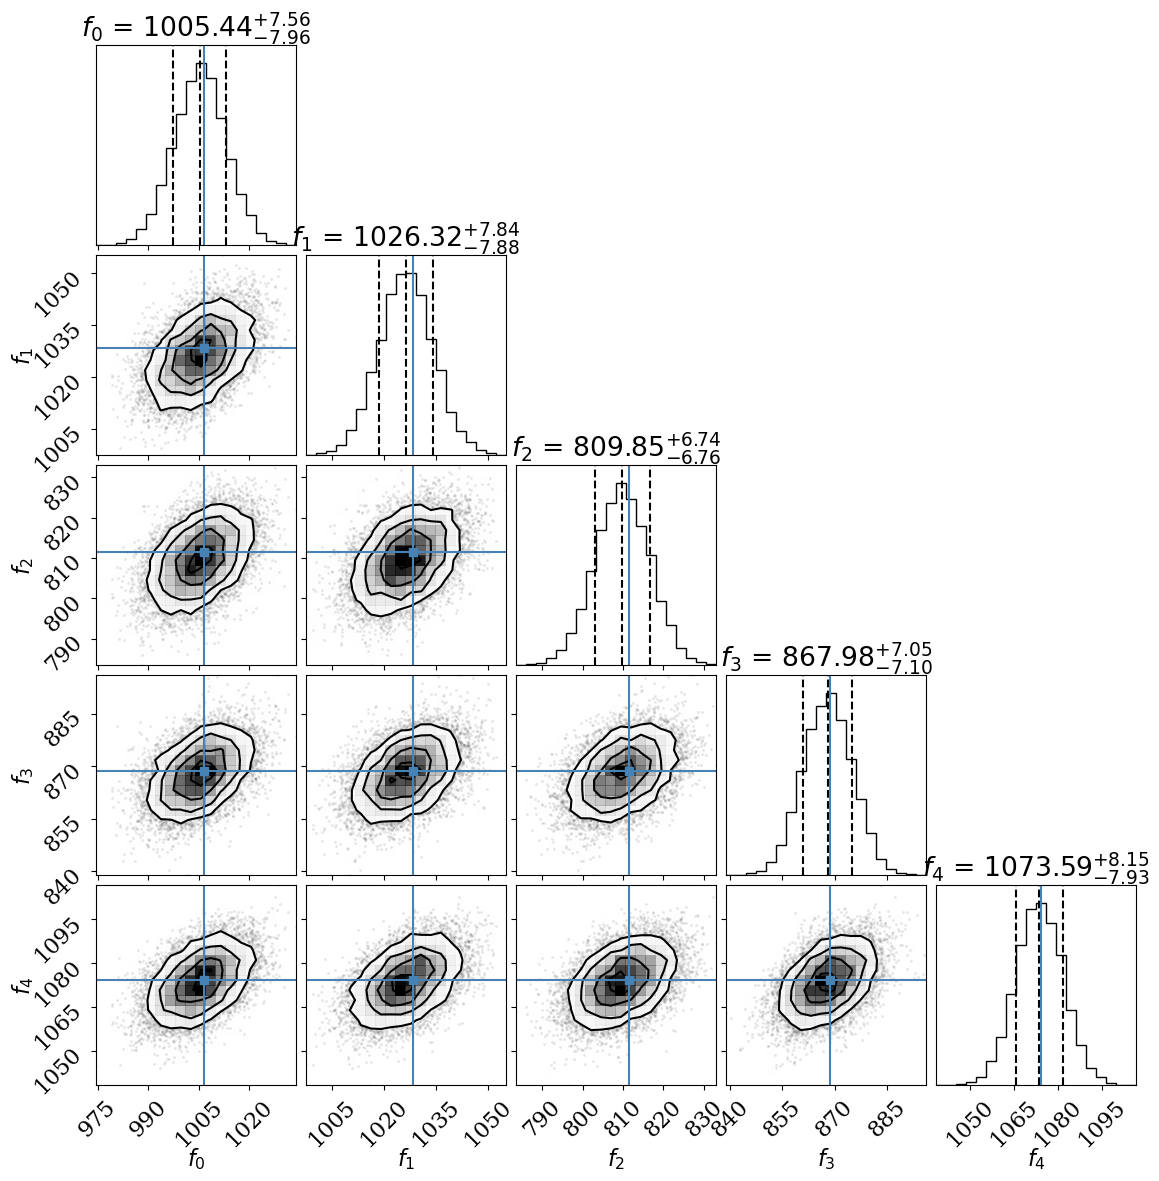

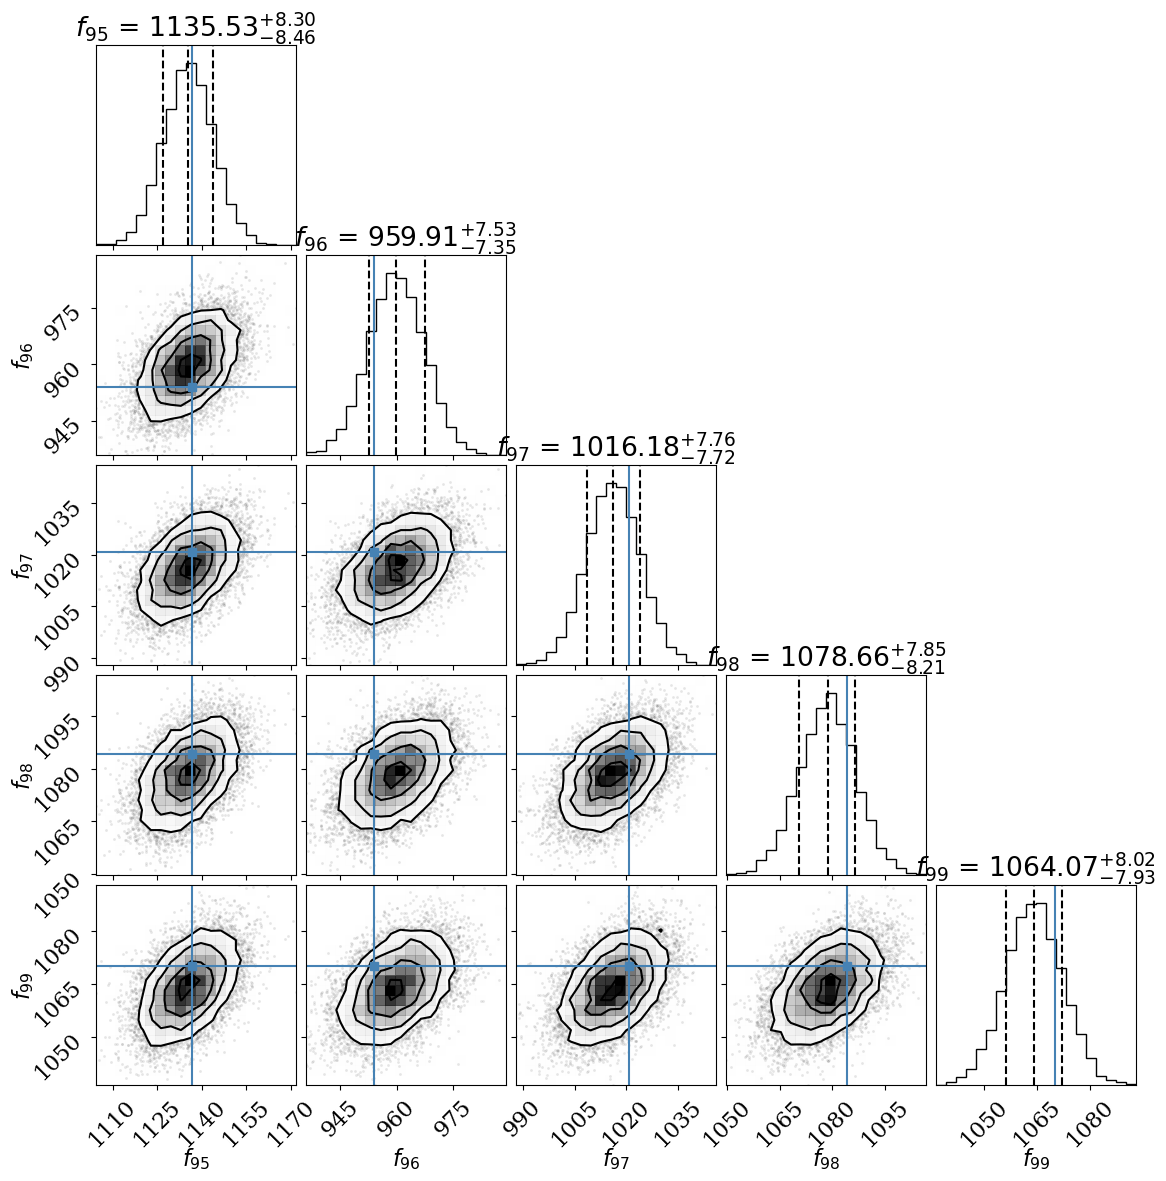

In [17]:
#f vector plots


plot_inds = np.arange(0,5).astype(int)
labels = []
for plot_ind in plot_inds:
    labels.append('$f_{%d}$'%plot_ind)
corner.corner(comb_param_samps[:,plot_inds],
              show_titles=True,quantiles=[0.16,0.50,0.84],
              truths=true_param_means[plot_inds],labels=labels,
              fontsize=14)
plt.show()
plot_inds = np.arange(-5,0).astype(int)+n_pixels
labels = []
for plot_ind in plot_inds:
    labels.append('$f_{%d}$'%plot_ind)
corner.corner(comb_param_samps[:,plot_inds],
              show_titles=True,quantiles=[0.16,0.50,0.84],
              truths=true_param_means[plot_inds],labels=labels)
plt.show()

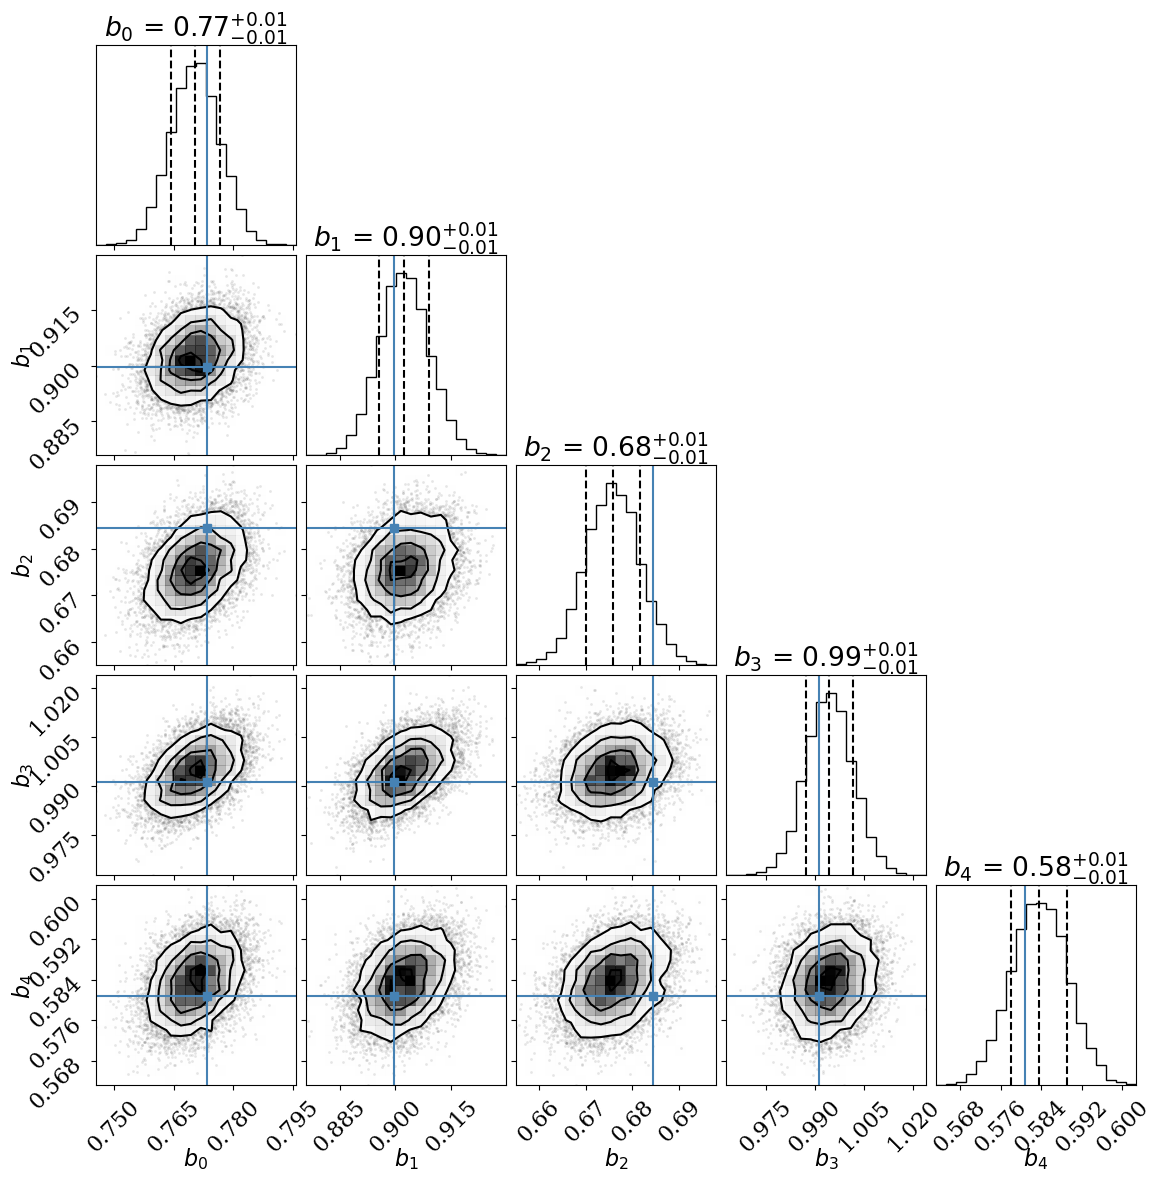

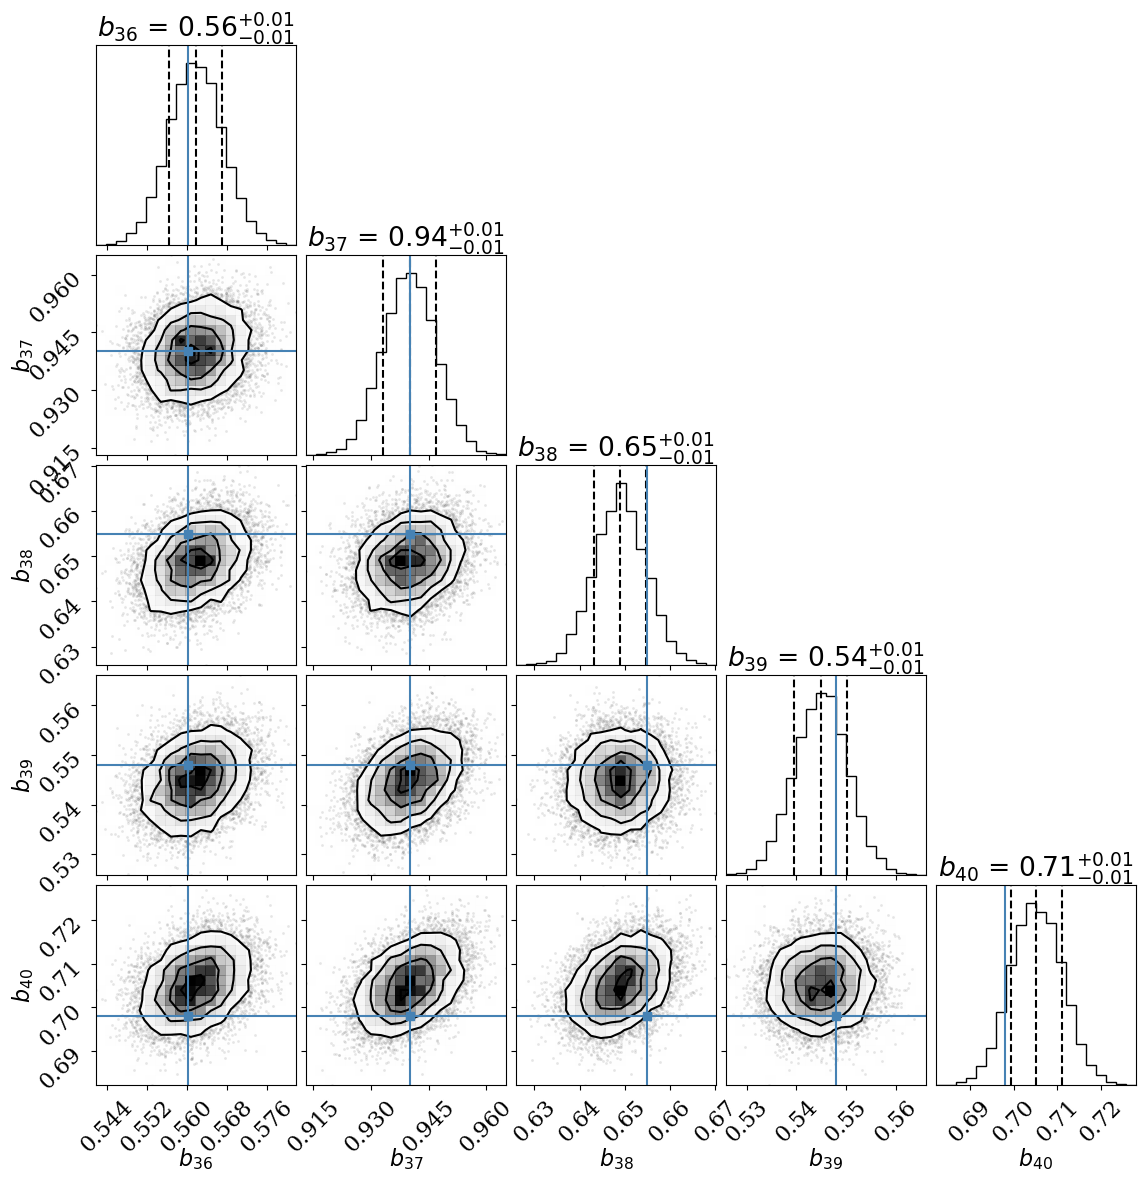

In [18]:
#b vector plots

plot_inds = np.arange(0,5).astype(int)+n_pixels
labels = []
for plot_ind in plot_inds:
    labels.append('$b_{%d}$'%non_max_inds[plot_ind-n_pixels])
corner.corner(comb_param_samps[:,plot_inds],
              show_titles=True,quantiles=[0.16,0.50,0.84],
              truths=true_param_means[plot_inds],labels=labels)
plt.show()
plot_inds = non_max_inds[-5:]+n_pixels-1
labels = []
for plot_ind in plot_inds:
    labels.append('$b_{%d}$'%non_max_inds[plot_ind-n_pixels])

corner.corner(comb_param_samps[:,plot_inds],
              show_titles=True,quantiles=[0.16,0.50,0.84],
              truths=true_param_means[plot_inds],labels=labels)
plt.show()

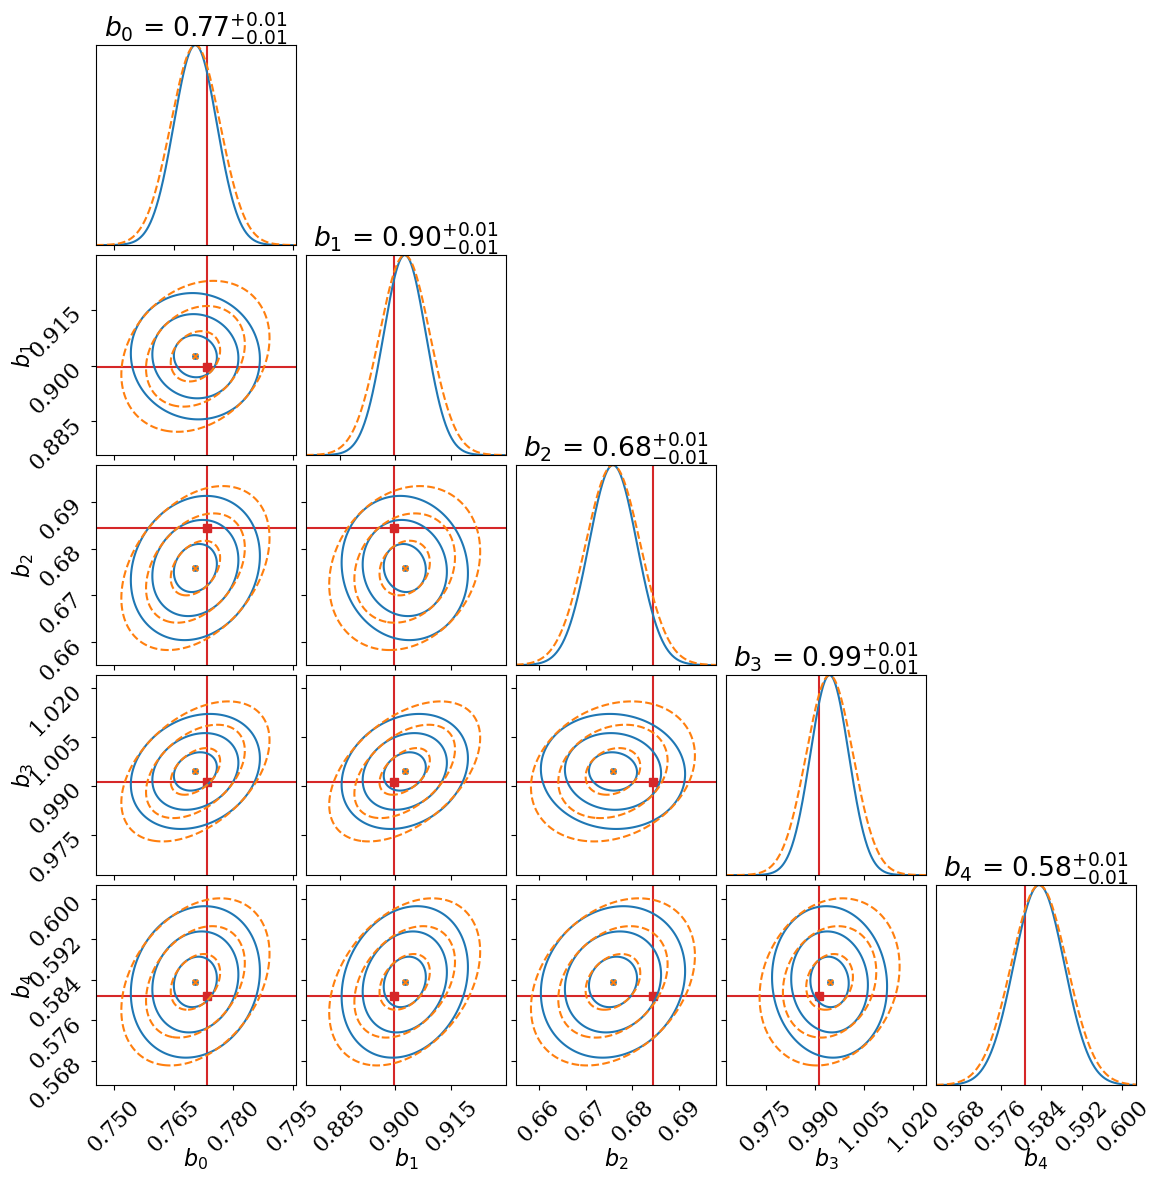

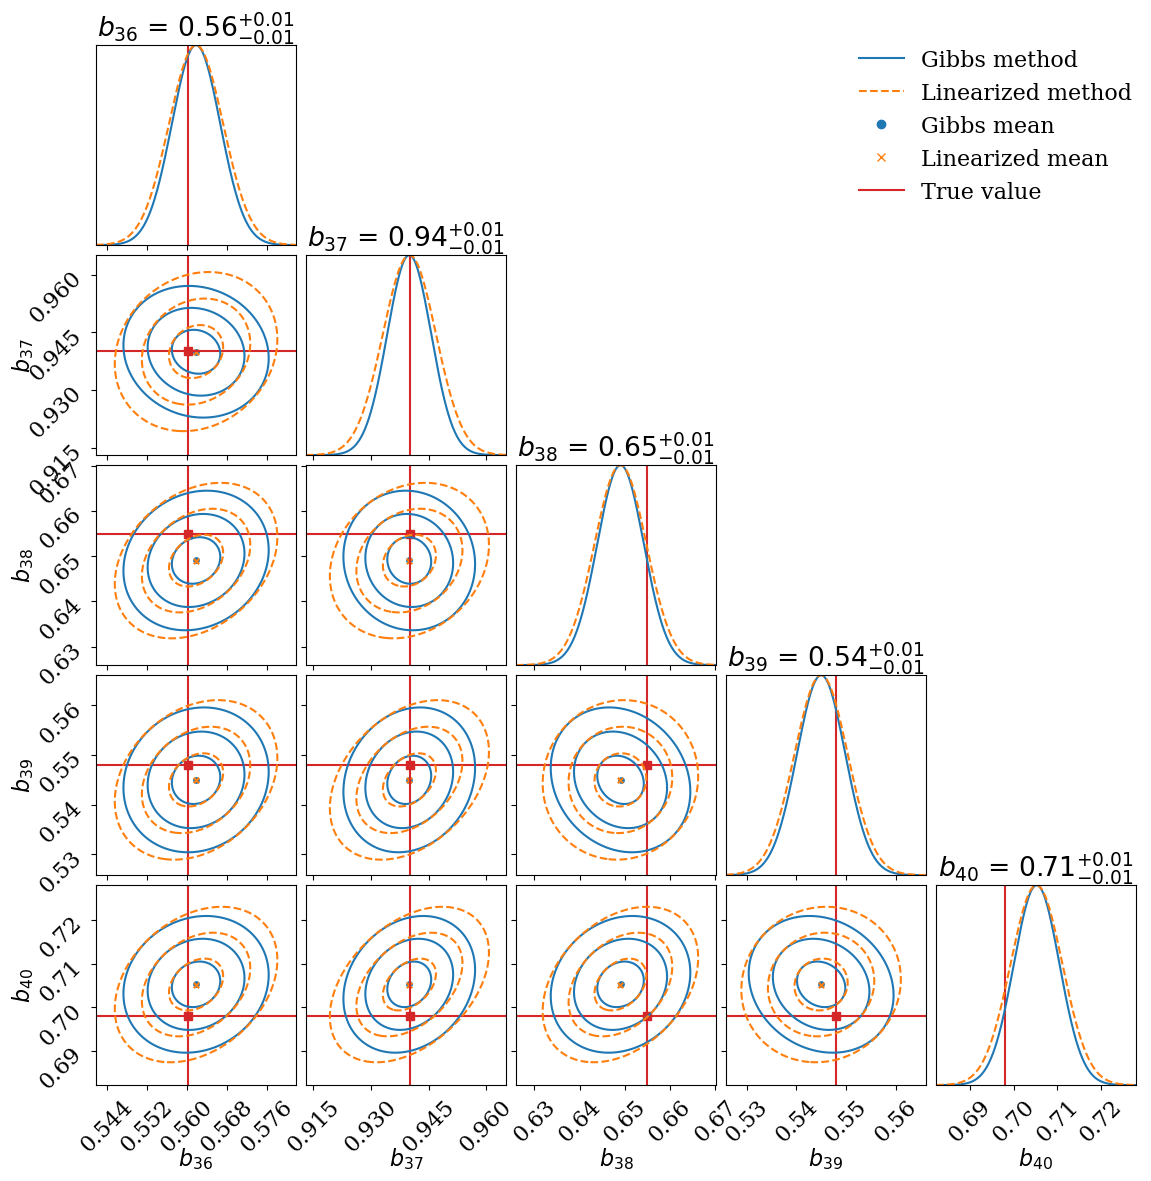

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from matplotlib.lines import Line2D
levels = [2.27886856637673, 5.99146454710798, 9.21034037197618]

def quad_form_grid(mean, cov, X, Y):
    """Compute Q(x) = (x - mean)^T cov^{-1} (x - mean) on a grid."""
    inv_cov = np.linalg.inv(cov)
    dx = X - mean[0]
    dy = Y - mean[1]
    D = np.stack([dx, dy], axis=-1)
    return np.einsum('...i,ij,...j->...', D, inv_cov, D)

def normal_pdf(x, mu, sigma):
    """1D normal pdf (no external distribution objects)."""
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

def add_b_contours_and_marginals_to_corner(fig, plot_inds, levels=(1.0, 4.0, 9.0)):
    """
    Add:
      - smooth Q-contours + means on the 2D panels,
      - 1D normal curves (Gibbs / Linear) on the diagonal hist panels.
    """
    ndim = len(plot_inds)
    orig_inds = non_max_inds[plot_inds - n_pixels]
    axes = np.array(fig.axes).reshape(ndim, ndim)

    # ----- diagonal: 1D normal curves on top of histograms -----
    for i in range(ndim):
        ax = axes[i, i]
        xlim = ax.get_xlim()
        x = np.linspace(xlim[0], xlim[1], 400)

        idx = orig_inds[i]

        # Gibbs mean/var
        mu_g = b_vect_mean_gibbs[idx]
        var_g = b_vect_cov_gibbs[idx, idx]
        sigma_g = np.sqrt(var_g)

        # Linear mean/var
        mu_l = b_vect_mean_linear[idx]
        var_l = b_vect_cov_linear[idx, idx]
        sigma_l = np.sqrt(var_l)

        y_g = normal_pdf(x, mu_g, sigma_g)
        y_l = normal_pdf(x, mu_l, sigma_l)

        # scale to match histogram height
        ymax = ax.get_ylim()[1]
        y_g_scaled = y_g / y_g.max() * ymax
        y_l_scaled = y_l / y_l.max() * ymax

        ax.plot(x, y_g_scaled, color='C0', lw=1.5)
        ax.plot(x, y_l_scaled, color='C1', lw=1.5, ls='--')

    # ----- off-diagonal: 2D Q-contours + means -----
    for iy in range(1, ndim):      # row (y)
        for ix in range(iy):       # col (x), lower triangle in corner
            ax = axes[iy, ix]

            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            x = np.linspace(xlim[0], xlim[1], 200)
            y = np.linspace(ylim[0], ylim[1], 200)
            X, Y = np.meshgrid(x, y)

            i_b = orig_inds[ix]
            j_b = orig_inds[iy]

            # Gibbs mean & cov
            gibbs_mean = np.array([b_vect_mean_gibbs[i_b],
                                   b_vect_mean_gibbs[j_b]])
            gibbs_cov = b_vect_cov_gibbs[np.ix_([i_b, j_b], [i_b, j_b])]

            # Linear mean & cov
            linear_mean = np.array([b_vect_mean_linear[i_b],
                                    b_vect_mean_linear[j_b]])
            linear_cov = b_vect_cov_linear[np.ix_([i_b, j_b], [i_b, j_b])]

            Q_gibbs = quad_form_grid(gibbs_mean, gibbs_cov, X, Y)
            Q_linear = quad_form_grid(linear_mean, linear_cov, X, Y)

            ax.contour(X, Y, Q_gibbs,  levels=levels, colors='C0', linewidths=1.5)
            ax.contour(X, Y, Q_linear, levels=levels, colors='C1',
                       linewidths=1.5, linestyles='--')

            ax.scatter(gibbs_mean[0],  gibbs_mean[1],  s=15, marker='o', color='C0')
            ax.scatter(linear_mean[0], linear_mean[1], s=15, marker='x', color='C1')


def add_corner_legend(fig):
    """Add a single legend for the whole corner figure."""
    handles = [
        Line2D([0], [0], color='C0', lw=1.5, linestyle='-',  label='Gibbs method'),
        Line2D([0], [0], color='C1', lw=1.5, linestyle='--', label='Linearized method'),
        Line2D([0], [0], marker='o', color='C0', linestyle='None',
               markersize=6, label='Gibbs mean'),
        Line2D([0], [0], marker='x', color='C1', linestyle='None',
               markersize=6, label='Linearized mean'),
        Line2D([0], [0], color='C3', lw=1.5, linestyle='-', label='True value'),
    ]
    fig.legend(handles=handles,
               loc='upper right',
               bbox_to_anchor=(0.98, 0.98),
               frameon=False)


# =======================
# First 5 b's
# =======================
plot_inds = np.arange(0, 5).astype(int) + n_pixels

labels = []
for plot_ind in plot_inds:
    labels.append('$b_{%d}$' % non_max_inds[plot_ind - n_pixels])

fig = corner.corner(
    comb_param_samps[:, plot_inds],
    show_titles=True,
    labels=labels,
    truths=true_param_means[plot_inds],  # keep true values
    truth_color='C3',
    plot_datapoints=False,
    fill_contours=False,
    plot_contours=False,
    #plot_density =False,
    plot_hist= False,
    pcolor_kwargs={"alpha": 0},
    hist_kwargs={"alpha": 0}
    
)

add_b_contours_and_marginals_to_corner(fig, plot_inds)
plt.show()

# =======================
# Last 5 b's
# =======================
plot_inds = non_max_inds[-5:] + n_pixels - 1

labels = []
for plot_ind in plot_inds:
    labels.append('$b_{%d}$' % non_max_inds[plot_ind - n_pixels])

fig = corner.corner(
    comb_param_samps[:, plot_inds],
    show_titles=True,
    labels=labels,
    truths=true_param_means[plot_inds],
    truth_color='C3',
    plot_datapoints=False,
    fill_contours=False,
    plot_contours=False,
    pcolor_kwargs={"alpha": 0},
    hist_kwargs={"alpha": 0}
)

add_b_contours_and_marginals_to_corner(fig, plot_inds)
add_corner_legend(fig)
plt.show()


In [20]:
f_gibbs = comb_param_mean_gibbs[:n_pixels]
b_gibbs = comb_param_mean_gibbs[n_pixels:]

f_linear = comb_param_mean_linear[:n_pixels]
b_linear = comb_param_mean_linear[n_pixels:]


# errors = sqrt(diagonal of covariance matrix)
error_gibbs = np.sqrt(np.diag(comb_param_V_gibbs))
error_linear = np.sqrt(np.diag(comb_param_V_linear))

# split into f and b parts
error_f_gibbs = error_gibbs[:n_pixels]
error_b_gibbs = error_gibbs[n_pixels:]

error_f_linear = error_linear[:n_pixels]
error_b_linear = error_linear[n_pixels:]

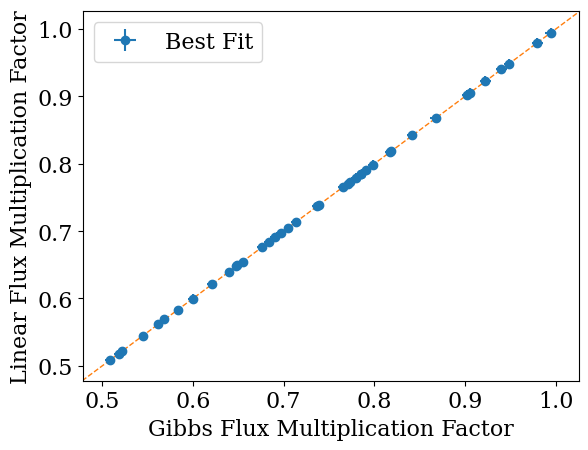

In [36]:
#scatter plot


plt.errorbar(b_gibbs,b_linear,yerr=error_b_linear,xerr=error_b_gibbs, fmt='o',label=r'Best Fit')

plt.ylabel('Linear Flux Multiplication Factor')
plt.xlabel('Gibbs Flux Multiplication Factor')
leg = plt.legend(loc='best')
xlim = plt.xlim()
ylim = plt.ylim()
line_xy = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
plt.plot(line_xy,line_xy,ls='--',lw=1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

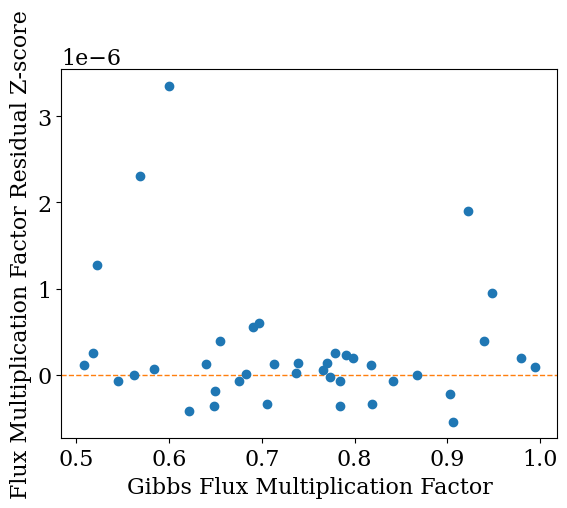

In [114]:
zscores = (b_linear-b_gibbs)*np.sqrt(error_b_linear**2+error_b_gibbs**2)
plt.errorbar(b_gibbs,zscores,fmt='o')
plt.axhline(0,c='C1',ls='--',lw=1)
plt.xlabel('Gibbs Flux Multiplication Factor')
plt.ylabel('Flux Multiplication Factor Residual Z-score')
plt.show()


array([ 1.30358035e-07, -2.20865392e-07, -7.46808300e-08,  8.61876327e-08,
        6.20236530e-08,  1.30624451e-07,  1.07770499e-07,  2.24136396e-07,
       -6.47084721e-09, -6.87908870e-08,  1.09845696e-07, -4.22023735e-07,
        2.28704325e-08,  5.48020730e-08,  1.93281254e-07,  1.17584075e-08,
       -3.64154976e-07, -2.67956093e-08,  3.89404186e-07,  1.28217761e-07,
        1.89759399e-06,  6.04001585e-07,  2.30097487e-06,  3.35697499e-06,
        1.27200482e-06,  9.52358069e-07,  2.56321014e-07, -3.65966953e-07,
        5.56208636e-07, -3.45110898e-07,  1.97982713e-07, -7.27112093e-08,
        1.18835408e-07, -5.45367673e-07,  2.55532516e-07, -2.76524419e-09,
        3.93241698e-07, -1.87737410e-07, -7.56968197e-08, -3.39194809e-07])

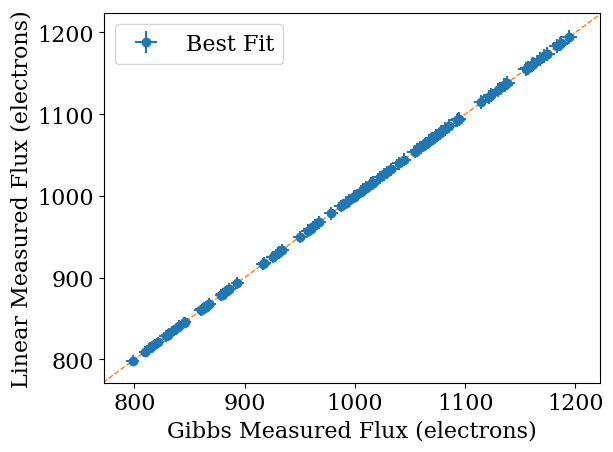

In [35]:
plt.errorbar(f_gibbs,f_linear,yerr=error_f_linear,xerr=error_f_gibbs,fmt='o',label=r'Best Fit')

plt.xlabel('Gibbs Measured Flux (electrons)')
plt.ylabel('Linear Measured Flux (electrons)')
leg = plt.legend(loc='best')
xlim = plt.xlim()
ylim = plt.ylim()
line_xy = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
plt.plot(line_xy,line_xy,ls='--',lw=1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

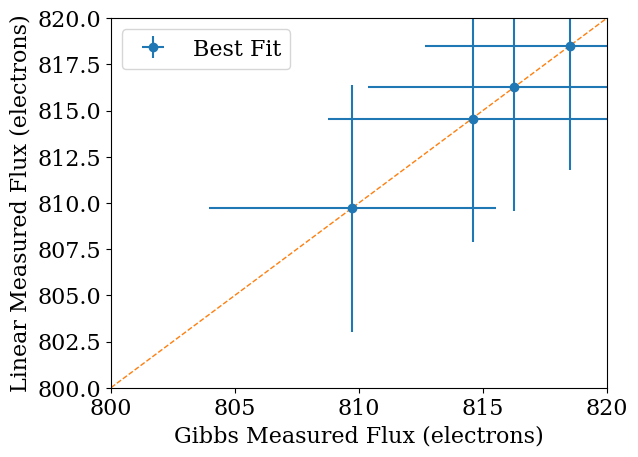

In [93]:
plt.errorbar(f_gibbs,f_linear,yerr=error_f_linear,xerr=error_f_gibbs,fmt='o',label=r'Best Fit')

plt.xlabel('Gibbs Measured Flux (electrons)')
plt.ylabel('Linear Measured Flux (electrons)')
leg = plt.legend(loc='best')
line_xy = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
plt.plot(line_xy,line_xy,ls='--',lw=1)
plt.xlim((800,820))
plt.ylim((800,820))
plt.show()

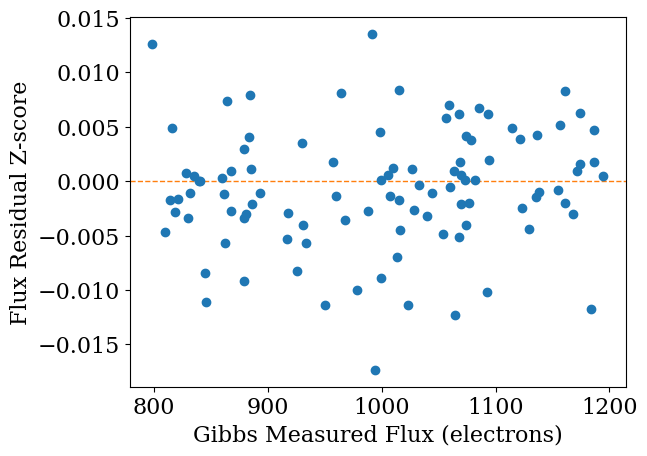

In [112]:
zscores = (f_linear-f_gibbs)/np.sqrt(error_f_linear**2+error_f_gibbs**2)
plt.errorbar(f_gibbs,zscores,fmt='o')
plt.axhline(0,c='C1',ls='--',lw=1)
plt.xlabel('Gibbs Measured Flux (electrons)')
plt.ylabel('Flux Residual Z-score')
plt.show()

In [111]:
np.sqrt(error_f_linear**2+error_f_gibbs**2)

array([10.20709054, 10.31488005,  8.82782287,  9.24527196, 10.64130516,
       11.03646669,  9.56515158, 11.16130817, 10.79334553,  9.3271204 ,
       10.33179023,  9.69019407,  9.19362212, 10.91855096, 11.41723693,
        9.37772503,  9.01790028, 10.39952852, 10.77941203,  9.39183157,
       10.58953394, 10.15574597,  8.88896306,  9.20775172,  9.33200024,
       11.4060715 , 10.12101114, 10.34530458, 10.69984499, 10.26150096,
       11.28911741, 10.92316501,  9.95478642,  9.78327532, 11.28419657,
        9.65675754, 11.16619469, 10.90250391, 10.2570693 , 11.26799521,
        8.97629789,  9.03891487, 10.60826301, 11.2386207 ,  9.23019152,
        9.54294559, 10.62094326,  9.31088836, 10.60983552, 10.11582735,
       10.58485299, 10.25143017,  8.95855654,  9.34634672, 10.31760075,
        9.01671559, 10.14401931,  9.20082856,  8.88945517,  9.21499092,
        9.93790986, 11.1949318 , 11.23555596, 10.05474112, 10.03327954,
       10.46096579,  9.70943718,  9.08900077,  8.9100639 , 10.59

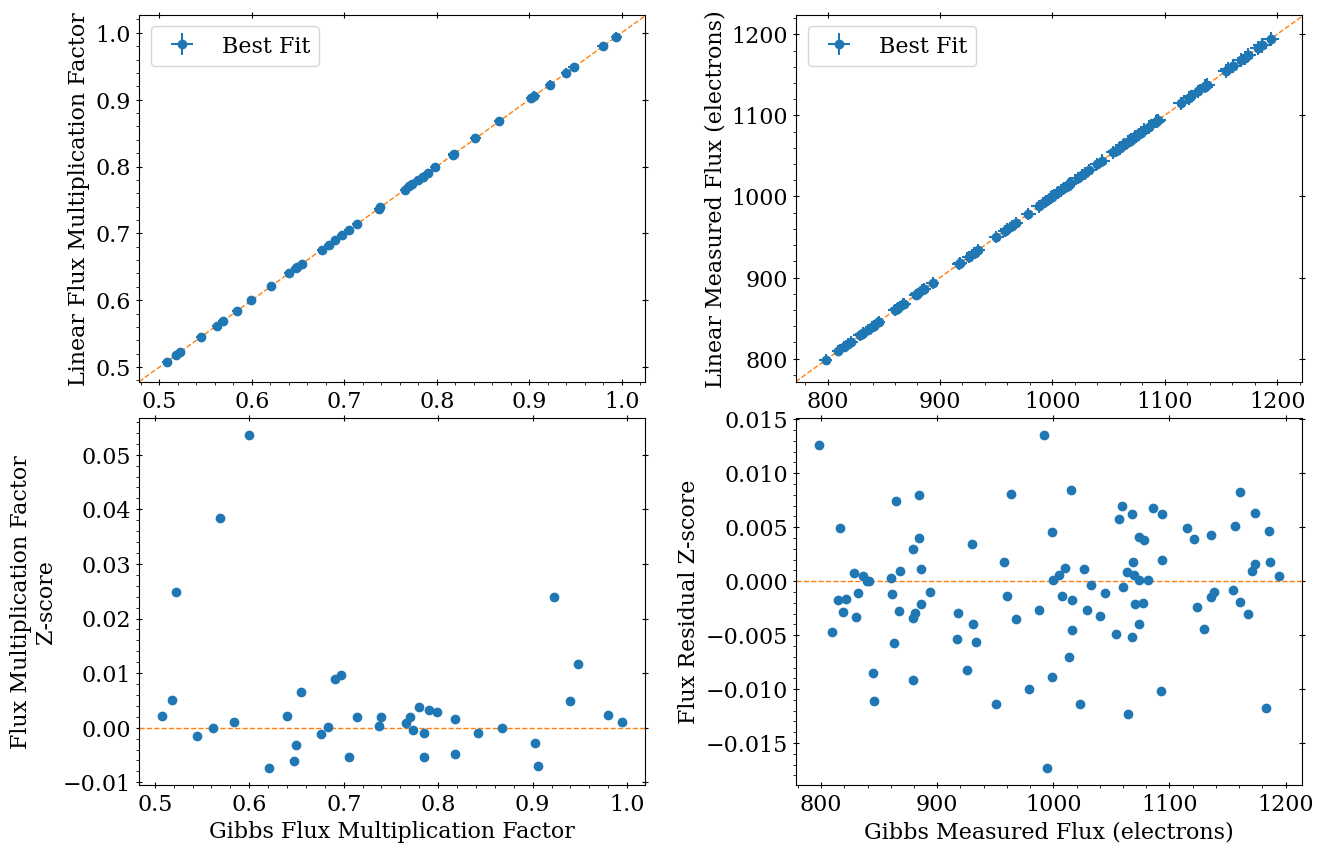

In [119]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2, wspace=0.3, hspace=0.1)

# -------------------------
# (0,0) b: Gibbs vs Linear
# -------------------------
ax = plt.subplot(gs[0, 0])
plt.minorticks_on()
ax.tick_params(axis='both', direction='inout', length=5,
               bottom=True, left=True, right=True, top=True)

plt.errorbar(b_gibbs, b_linear,
             yerr=error_b_linear, xerr=error_b_gibbs,
             fmt='o', label=r'Best Fit')

plt.ylabel('Linear Flux Multiplication Factor')
leg = plt.legend(loc='best')

xlim = plt.xlim()
ylim = plt.ylim()
line_xy = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
plt.plot(line_xy, line_xy, ls='--', lw=1)
plt.xlim(xlim)
plt.ylim(ylim)

# -------------------------
# (1,0) b: residual "z-score"
# -------------------------
ax = plt.subplot(gs[1, 0])
plt.minorticks_on()
ax.tick_params(axis='both', direction='inout', length=5,
               bottom=True, left=True, right=True, top=True)

zscores_b = (b_linear - b_gibbs) / np.sqrt(error_b_linear**2 + error_b_gibbs**2)
plt.errorbar(b_gibbs, zscores_b, fmt='o')
plt.axhline(0, c='C1', ls='--', lw=1)
plt.xlabel('Gibbs Flux Multiplication Factor')
plt.ylabel('Flux Multiplication Factor\nZ-score')

# -------------------------
# (0,1) f: Gibbs vs Linear
# -------------------------
ax = plt.subplot(gs[0, 1])
plt.minorticks_on()
ax.tick_params(axis='both', direction='inout', length=5,
               bottom=True, left=True, right=True, top=True)

plt.errorbar(f_gibbs, f_linear,
             yerr=error_f_linear, xerr=error_f_gibbs,
             fmt='o', label=r'Best Fit')

plt.ylabel('Linear Measured Flux (electrons)')
leg = plt.legend(loc='best')

xlim = plt.xlim()
ylim = plt.ylim()
line_xy = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
plt.plot(line_xy, line_xy, ls='--', lw=1)
plt.xlim(xlim)
plt.ylim(ylim)

# -------------------------
# (1,1) f: residual "z-score"
# -------------------------
ax = plt.subplot(gs[1, 1])
plt.minorticks_on()
ax.tick_params(axis='both', direction='inout', length=5,
               bottom=True, left=True, right=True, top=True)

zscores_f = (f_linear - f_gibbs) / np.sqrt(error_f_linear**2 + error_f_gibbs**2)
plt.errorbar(f_gibbs, zscores_f, fmt='o')
plt.axhline(0, c='C1', ls='--', lw=1)
plt.xlabel('Gibbs Measured Flux (electrons)')
plt.ylabel('Flux Residual Z-score')

plt.savefig("gibbs_vs_linear_comparison.png", dpi=300)

plt.show()


[0 1]


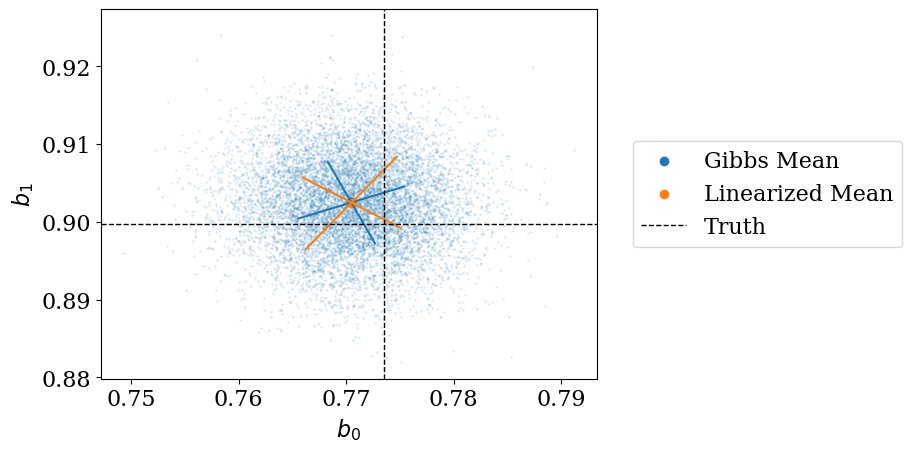

In [23]:
b_inds = np.array([0,1])
#b_inds = np.array([22,23])-1
orig_b_inds = non_max_inds[b_inds]
comb_inds = b_inds+n_pixels
true_param_means

print(orig_b_inds)

plt.scatter(comb_param_samps_gibbs[:,comb_inds[0]],
            comb_param_samps_gibbs[:,comb_inds[1]],
            s=1,alpha=0.1)
# plt.scatter(comb_param_samps_linear[:,comb_inds[0]],
#             comb_param_samps_linear[:,comb_inds[1]],
#             s=1,alpha=0.1)

curr_med = b_vect_mean_gibbs[orig_b_inds]
curr_cov = np.zeros((2,2))
curr_cov[0,0] = b_vect_cov_gibbs[orig_b_inds[0],orig_b_inds[0]]
curr_cov[0,1] = b_vect_cov_gibbs[orig_b_inds[0],orig_b_inds[1]]
curr_cov[1,0] = b_vect_cov_gibbs[orig_b_inds[1],orig_b_inds[0]]
curr_cov[1,1] = b_vect_cov_gibbs[orig_b_inds[1],orig_b_inds[1]]
curr_vals,curr_vects = np.linalg.eig(curr_cov)
curr_vals = np.sqrt(curr_vals)
err_vects = np.zeros_like(curr_vects)
err_vects[0] = curr_vals[0]*curr_vects[:,0]
err_vects[1] = curr_vals[1]*curr_vects[:,1]    

err1_plot = [curr_med[0]-err_vects[0,0],curr_med[0]+err_vects[0,0]],\
            [curr_med[1]-err_vects[0,1],curr_med[1]+err_vects[0,1]]
err2_plot = [curr_med[0]-err_vects[1,0],curr_med[0]+err_vects[1,0]],\
            [curr_med[1]-err_vects[1,1],curr_med[1]+err_vects[1,1]]
color = 'C0'
plt.scatter(curr_med[0],curr_med[1],
            marker='o',label='Gibbs Mean',color=color)
plt.plot(err1_plot[0],err1_plot[1],color=color)
plt.plot(err2_plot[0],err2_plot[1],color=color)

curr_med = b_vect_mean_linear[orig_b_inds]
curr_cov = np.zeros((2,2))
curr_cov[0,0] = b_vect_cov_linear[orig_b_inds[0],orig_b_inds[0]]
curr_cov[0,1] = b_vect_cov_linear[orig_b_inds[0],orig_b_inds[1]]
curr_cov[1,0] = b_vect_cov_linear[orig_b_inds[1],orig_b_inds[0]]
curr_cov[1,1] = b_vect_cov_linear[orig_b_inds[1],orig_b_inds[1]]
curr_vals,curr_vects = np.linalg.eig(curr_cov)
curr_vals = np.sqrt(curr_vals)
err_vects = np.zeros_like(curr_vects)
err_vects[0] = curr_vals[0]*curr_vects[:,0]
err_vects[1] = curr_vals[1]*curr_vects[:,1]    

err1_plot = [curr_med[0]-err_vects[0,0],curr_med[0]+err_vects[0,0]],\
            [curr_med[1]-err_vects[0,1],curr_med[1]+err_vects[0,1]]
err2_plot = [curr_med[0]-err_vects[1,0],curr_med[0]+err_vects[1,0]],\
            [curr_med[1]-err_vects[1,1],curr_med[1]+err_vects[1,1]]
color = 'C1'
plt.scatter(curr_med[0],curr_med[1],
            marker='o',label='Linearized Mean',color=color)
plt.plot(err1_plot[0],err1_plot[1],color=color)
plt.plot(err2_plot[0],err2_plot[1],color=color)
# plt.errorbar(b_vect_mean_gibbs[orig_b_inds[0]],b_vect_mean_gibbs[orig_b_inds[1]],
#              xerr=b_vect_errs_gibbs[orig_b_inds[0]],
#              yerr=b_vect_errs_gibbs[orig_b_inds[1]],
#              fmt='o',label='Gibbs Mean')
# plt.errorbar(b_vect_mean_linear[orig_b_inds[0]],b_vect_mean_linear[orig_b_inds[1]],
#              xerr=b_vect_errs_linear[orig_b_inds[0]],
#              yerr=b_vect_errs_linear[orig_b_inds[1]],
#              fmt='o',label='Linearized Mean')
plt.axhline(true_param_means[comb_inds[1]],c='k',lw=1,ls='--',label='Truth')
plt.axvline(true_param_means[comb_inds[0]],c='k',lw=1,ls='--')
plt.xlabel('$b_{%d}$'%orig_b_inds[0])
plt.ylabel('$b_{%d}$'%orig_b_inds[1])
plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
plt.show()


[0 1]


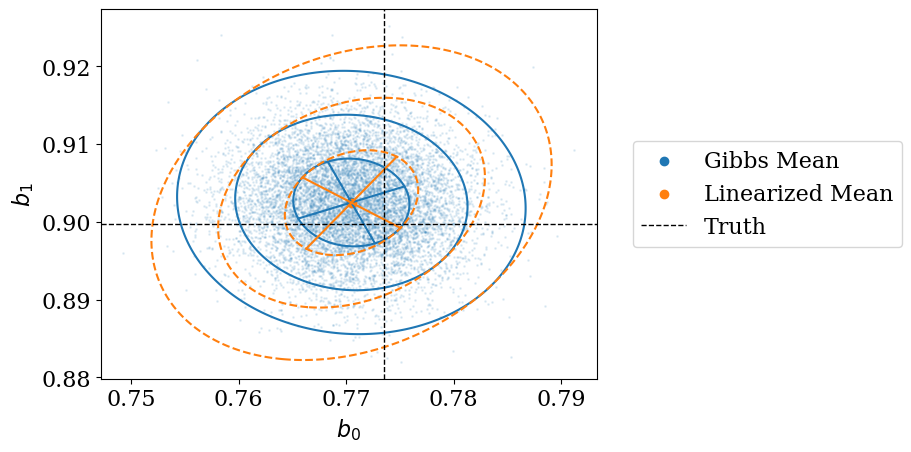

In [24]:
b_inds = np.array([0,1])
# b_inds = np.array([22,23]) - 1
orig_b_inds = non_max_inds[b_inds]
comb_inds = b_inds + n_pixels
true_param_means

print(orig_b_inds)

# --- Scatter plot (sets the initial axis limits we want to keep) ---
plt.scatter(comb_param_samps_gibbs[:, comb_inds[0]],
            comb_param_samps_gibbs[:, comb_inds[1]],
            s=1, alpha=0.1)

# Get axis limits from this initial scatter (we will reuse them for the contour grid)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Build grid that matches EXACTLY the initial scatter extent
x = np.linspace(xlim[0], xlim[1], 300)
y = np.linspace(ylim[0], ylim[1], 300)
X, Y = np.meshgrid(x, y)

def quad_form_grid(mean, cov, X, Y):
    """
    Compute Q(x) = (x - mean)^T cov^{-1} (x - mean) on a grid.
    """
    inv_cov = np.linalg.inv(cov)
    dx = X - mean[0]
    dy = Y - mean[1]
    D = np.stack([dx, dy], axis=-1)
    Q = np.einsum('...i,ij,...j->...', D, inv_cov, D)
    return Q

levels = [1.0, 4.0, 9.0]  # e.g. ~1, 2, 3 "sigma" levels

# ---------------- Gibbs ----------------
curr_med = b_vect_mean_gibbs[orig_b_inds]
curr_cov = np.zeros((2, 2))
curr_cov[0, 0] = b_vect_cov_gibbs[orig_b_inds[0], orig_b_inds[0]]
curr_cov[0, 1] = b_vect_cov_gibbs[orig_b_inds[0], orig_b_inds[1]]
curr_cov[1, 0] = b_vect_cov_gibbs[orig_b_inds[1], orig_b_inds[0]]
curr_cov[1, 1] = b_vect_cov_gibbs[orig_b_inds[1], orig_b_inds[1]]

# Q-contour for Gibbs (color C0, no label on contour itself)
Q_gibbs = quad_form_grid(curr_med, curr_cov, X, Y)
plt.contour(X, Y, Q_gibbs, levels=levels, colors='C0')

# Error-bar style eigenvector lines (same as your original)
curr_vals, curr_vects = np.linalg.eig(curr_cov)
curr_vals = np.sqrt(curr_vals)
err_vects = np.zeros_like(curr_vects)
err_vects[0] = curr_vals[0] * curr_vects[:, 0]
err_vects[1] = curr_vals[1] * curr_vects[:, 1]

err1_plot = [curr_med[0] - err_vects[0, 0], curr_med[0] + err_vects[0, 0]], \
            [curr_med[1] - err_vects[0, 1], curr_med[1] + err_vects[0, 1]]
err2_plot = [curr_med[0] - err_vects[1, 0], curr_med[0] + err_vects[1, 0]], \
            [curr_med[1] - err_vects[1, 1], curr_med[1] + err_vects[1, 1]]
color = 'C0'
plt.scatter(curr_med[0], curr_med[1],
            marker='o', label='Gibbs Mean', color=color)
plt.plot(err1_plot[0], err1_plot[1], color=color)
plt.plot(err2_plot[0], err2_plot[1], color=color)

# ---------------- Linearized ----------------
curr_med = b_vect_mean_linear[orig_b_inds]
curr_cov = np.zeros((2, 2))
curr_cov[0, 0] = b_vect_cov_linear[orig_b_inds[0], orig_b_inds[0]]
curr_cov[0, 1] = b_vect_cov_linear[orig_b_inds[0], orig_b_inds[1]]
curr_cov[1, 0] = b_vect_cov_linear[orig_b_inds[1], orig_b_inds[0]]
curr_cov[1, 1] = b_vect_cov_linear[orig_b_inds[1], orig_b_inds[1]]

# Q-contour for Linearized (color C1, dashed)
Q_linear = quad_form_grid(curr_med, curr_cov, X, Y)
plt.contour(X, Y, Q_linear, levels=levels, colors='C1', linestyles='--')

curr_vals, curr_vects = np.linalg.eig(curr_cov)
curr_vals = np.sqrt(curr_vals)
err_vects = np.zeros_like(curr_vects)
err_vects[0] = curr_vals[0] * curr_vects[:, 0]
err_vects[1] = curr_vals[1] * curr_vects[:, 1]

err1_plot = [curr_med[0] - err_vects[0, 0], curr_med[0] + err_vects[0, 0]], \
            [curr_med[1] - err_vects[0, 1], curr_med[1] + err_vects[0, 1]]
err2_plot = [curr_med[0] - err_vects[1, 0], curr_med[0] + err_vects[1, 0]], \
            [curr_med[1] - err_vects[1, 1], curr_med[1] + err_vects[1, 1]]
color = 'C1'
plt.scatter(curr_med[0], curr_med[1],
            marker='o', label='Linearized Mean', color=color)
plt.plot(err1_plot[0], err1_plot[1], color=color)
plt.plot(err2_plot[0], err2_plot[1], color=color)

# ---------------- Truth lines and labels ----------------
plt.axhline(true_param_means[comb_inds[1]], c='k', lw=1, ls='--', label='Truth')
plt.axvline(true_param_means[comb_inds[0]], c='k', lw=1, ls='--')
plt.xlabel('$b_{%d}$' % orig_b_inds[0])
plt.ylabel('$b_{%d}$' % orig_b_inds[1])
plt.legend(loc=6, bbox_to_anchor=(1.05, 0.5))
plt.show()


[0 1]


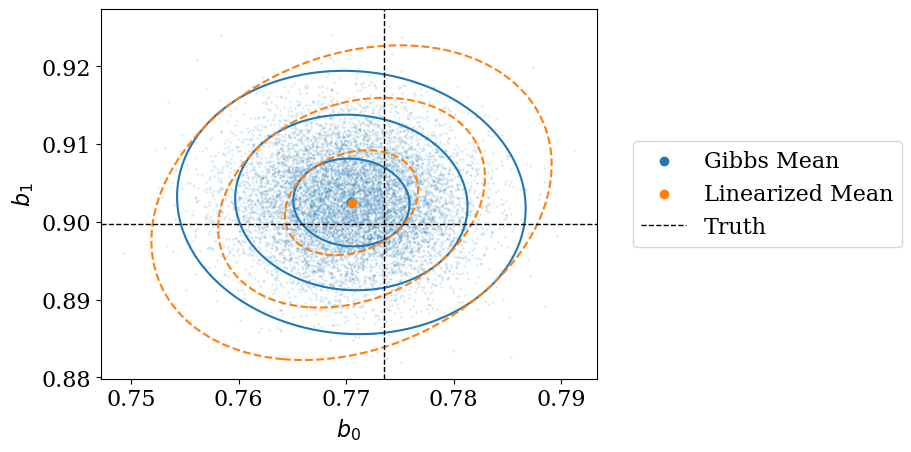

In [25]:
b_inds = np.array([0,1])
# b_inds = np.array([22,23]) - 1
orig_b_inds = non_max_inds[b_inds]
comb_inds = b_inds + n_pixels
true_param_means

print(orig_b_inds)

# --- Scatter plot (sets the axis limits we want to keep) ---
plt.scatter(comb_param_samps_gibbs[:, comb_inds[0]],
            comb_param_samps_gibbs[:, comb_inds[1]],
            s=1, alpha=0.1)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Grid that matches exactly the scatter extent
x = np.linspace(xlim[0], xlim[1], 300)
y = np.linspace(ylim[0], ylim[1], 300)
X, Y = np.meshgrid(x, y)

def quad_form_grid(mean, cov, X, Y):
    """Compute Q(x) = (x - mean)^T cov^{-1} (x - mean) on a grid."""
    inv_cov = np.linalg.inv(cov)
    dx = X - mean[0]
    dy = Y - mean[1]
    D = np.stack([dx, dy], axis=-1)
    return np.einsum('...i,ij,...j->...', D, inv_cov, D)

levels = [1.0, 4.0, 9.0]  # "1, 2, 3 sigma" style levels

# ---------------- Gibbs ----------------
gibbs_mean = b_vect_mean_gibbs[orig_b_inds]
gibbs_cov = np.zeros((2, 2))
gibbs_cov[0, 0] = b_vect_cov_gibbs[orig_b_inds[0], orig_b_inds[0]]
gibbs_cov[0, 1] = b_vect_cov_gibbs[orig_b_inds[0], orig_b_inds[1]]
gibbs_cov[1, 0] = b_vect_cov_gibbs[orig_b_inds[1], orig_b_inds[0]]
gibbs_cov[1, 1] = b_vect_cov_gibbs[orig_b_inds[1], orig_b_inds[1]]

Q_gibbs = quad_form_grid(gibbs_mean, gibbs_cov, X, Y)
plt.contour(X, Y, Q_gibbs, levels=levels, colors='C0')  # contour only

plt.scatter(gibbs_mean[0], gibbs_mean[1],
            marker='o', label='Gibbs Mean', color='C0')

# ---------------- Linearized ----------------
linear_mean = b_vect_mean_linear[orig_b_inds]
linear_cov = np.zeros((2, 2))
linear_cov[0, 0] = b_vect_cov_linear[orig_b_inds[0], orig_b_inds[0]]
linear_cov[0, 1] = b_vect_cov_linear[orig_b_inds[0], orig_b_inds[1]]
linear_cov[1, 0] = b_vect_cov_linear[orig_b_inds[1], orig_b_inds[0]]
linear_cov[1, 1] = b_vect_cov_linear[orig_b_inds[1], orig_b_inds[1]]

Q_linear = quad_form_grid(linear_mean, linear_cov, X, Y)
plt.contour(X, Y, Q_linear, levels=levels, colors='C1', linestyles='--')

plt.scatter(linear_mean[0], linear_mean[1],
            marker='o', label='Linearized Mean', color='C1')

# ---------------- Truth lines and labels ----------------
plt.axhline(true_param_means[comb_inds[1]], c='k', lw=1, ls='--', label='Truth')
plt.axvline(true_param_means[comb_inds[0]], c='k', lw=1, ls='--')

plt.xlabel('$b_{%d}$' % orig_b_inds[0])
plt.ylabel('$b_{%d}$' % orig_b_inds[1])
plt.legend(loc=6, bbox_to_anchor=(1.05, 0.5))
plt.show()


In [ ]:
def chi2_total(curr_f_max,curr_b_vect,obs_flux_diffs,read_Vs):
    curr_model = curr_f_max[:,None] * curr_b_vect[None,:]
    curr_data_diffs = np.maximum(curr_model,0)
    data_V = np.zeros((n_pixels,n_reads-1,n_reads-1))
    for p_ind in range(n_pixels):
        data_V[p_ind] = np.diag(curr_data_diffs[p_ind])
    comb_V_inv = np.linalg.inv(data_V + read_Vs)

    data_diffs = obs_flux_diffs-curr_model
    return np.sum(np.einsum('ni,ni->n',data_diffs,np.einsum('nij,nj->ni',comb_V_inv,data_diffs)),axis=0)

def measure_time_dep_fluxes_HESSIAN(obs_fluxes,read_errs,
                                    n_repeat=2,b_vect_change_tol=1e-6,
                                    min_b_val=1e-10,min_f_val=1e-10,
                                    rescale=False,true_b_vect=None,
                                    true_fluxes=None):
    
    '''
    takes observed counts (shape of n_pixels,n_reads) 
    and returns the best-fit vect b and vect f with assocaited covariance matrix

    inputs:
        obs_fluxes: observed counts, units of electrons, shape (n_pixels,n_reads)
        read_errs: read noise per pixel, units of electrons, shape (n_pixels)
        n_repeat: number of times to update the f,b vectors (should probably be 2)
        b_vect_change_tol: stop updating if the b vect values have changed by less than this tolerance
        min_b_val: minimum value the b vector elements can take (should not be less than 0)
        min_f_val: minimum value the f vector elements can take (should not be less than 0)
        rescale: if True, then use the input true b vector to scale f and b vectors (which can be done arbitrarily)
        true_b_vect: if rescale is True, then use true_b_vect to rescale the output f and b vectors

    outputs:
        max_b_ind: the index of the maximum element in b_vect_guess (scaled to be equal to 1)
        curr_b_vect: the b vector mean
        curr_b_Vinv: the b vector inverse covariance matrix
        curr_b_V: the b vector covariance matrix
        f_max_means_given_b: the f means given the final b mean
        f_max_ivars_given_b: the f ivars given the final b mean
        comb_param_means: the combined f and b vector mean
        comb_param_Vinv: the combined f and b vector inverse covariance matrix
        comb_param_V: the combined f and b vector covariance matrix
    '''

    n_reads = obs_fluxes.shape[1]
    n_pixels = obs_fluxes.shape[0]
    read_vars = np.power(read_errs,2)

    obs_flux_diffs = np.diff(obs_fluxes,axis=1)
    b_vect_guess,fmax_guess,max_b_ind = first_guess_parameters(obs_flux_diffs,read_vars,
                                           min_b_val=min_b_val,min_f_val=min_f_val)

    #define read covariance matrix 
    #(i.e. 2*read_var on diagonal, -1*read_var on one-from-diagonal)
    read_Vs = np.zeros((n_pixels,n_reads-1,n_reads-1))
    for p_ind in range(n_pixels):
        read_Vs[p_ind,np.arange(n_reads-1),np.arange(n_reads-1)] = 2*read_vars[p_ind]
        for j in range(len(read_Vs[p_ind])-1):
            read_Vs[p_ind,j,j+1] = -read_vars[p_ind]
            read_Vs[p_ind,j+1,j] = -read_vars[p_ind]

    #define matrix and vector needed to 
    #keep max element of b at exactly 1
    mat_01 = np.eye(n_reads-1)
    mat_01[max_b_ind,max_b_ind] = 0
    vec_10 = np.zeros(n_reads-1)
    vec_10[max_b_ind] = 1

    #define vectors that will be updated during iteration
    curr_b_vect = np.copy(b_vect_guess)
    curr_f_max = np.copy(fmax_guess)
    curr_f_max = np.maximum(curr_f_max,min_f_val)
    curr_b_vect = np.maximum(curr_b_vect,min_b_val)

    non_max_inds = np.ones(len(curr_b_vect)).astype(bool)
    non_max_inds[max_b_ind] = False
    non_max_inds = np.where(non_max_inds)[0]

    for r_ind in range(n_repeat):
    
        chi0 = chi2_total(curr_f_max,curr_b_vect,obs_flux_diffs,read_Vs)
    
        comb_param_means = np.zeros(n_pixels+n_reads-2)
        comb_param_means[:n_pixels] = curr_f_max
        comb_param_means[n_pixels:] = curr_b_vect[non_max_inds]
    
        df = np.maximum(curr_f_max/1000,min_f_val)
        db = np.maximum(curr_b_vect/1000,min_b_val)
        dvect = np.zeros_like(comb_param_means)
        dvect[:n_pixels] = df
        dvect[n_pixels:] = db[non_max_inds]
        curr_dvect = np.zeros_like(dvect)
        
        jacobian = np.zeros_like(comb_param_means)
        hessian = np.zeros((len(comb_param_means),len(comb_param_means)))
    
        test_f_max_above = np.copy(curr_f_max)
        test_b_vect_above = np.copy(curr_b_vect)
        test_f_max_below = np.copy(curr_f_max)
        test_b_vect_below = np.copy(curr_b_vect)
    
        test_f_max_above1 = np.copy(curr_f_max)
        test_b_vect_above1 = np.copy(curr_b_vect)
        test_f_max_above2 = np.copy(curr_f_max)
        test_b_vect_above2 = np.copy(curr_b_vect)
        test_f_max_below1 = np.copy(curr_f_max)
        test_b_vect_below1 = np.copy(curr_b_vect)
        test_f_max_below2 = np.copy(curr_f_max)
        test_b_vect_below2 = np.copy(curr_b_vect)

        for j in range(len(comb_param_means)):
            curr_dvect[:] = 0
            curr_dvect[j] = dvect[j]
    
            test_param_means_above = comb_param_means + curr_dvect
            test_f_max_above = test_param_means_above[:n_pixels]
            test_b_vect_above[non_max_inds] = test_param_means_above[n_pixels:]
            test_param_means_below = comb_param_means - curr_dvect
            test_f_max_below = test_param_means_below[:n_pixels]
            test_b_vect_below[non_max_inds] = test_param_means_below[n_pixels:]
    
            curr_chi_above = chi2_total(test_f_max_above,test_b_vect_above,obs_flux_diffs,read_Vs)
            curr_chi_below = chi2_total(test_f_max_below,test_b_vect_below,obs_flux_diffs,read_Vs)
    
            jacobian[j] = (curr_chi_above - curr_chi_below) / (2*dvect[j])
            
            for k in range(j,len(comb_param_means)):
                curr_dvect[:] = 0
                curr_dvect[k] = dvect[k]
    
                test_param_means_above1 = test_param_means_above + curr_dvect
                test_f_max_above1 = test_param_means_above1[:n_pixels]
                test_b_vect_above1[non_max_inds] = test_param_means_above1[n_pixels:]
                test_param_means_above2 = test_param_means_above - curr_dvect
                test_f_max_above2 = test_param_means_above2[:n_pixels]
                test_b_vect_above2[non_max_inds] = test_param_means_above2[n_pixels:]
    
                curr_chi_above1 = chi2_total(test_f_max_above1,test_b_vect_above1,obs_flux_diffs,read_Vs)
                curr_chi_above2 = chi2_total(test_f_max_above2,test_b_vect_above2,obs_flux_diffs,read_Vs)
    
                deriv_above = (curr_chi_above1-curr_chi_above2)/(2*dvect[k])
            
                test_param_means_below1 = test_param_means_below + curr_dvect
                test_f_max_below1 = test_param_means_below1[:n_pixels]
                test_b_vect_below1[non_max_inds] = test_param_means_below1[n_pixels:]
                test_param_means_below2 = test_param_means_below - curr_dvect
                test_f_max_below2 = test_param_means_below2[:n_pixels]
                test_b_vect_below2[non_max_inds] = test_param_means_below2[n_pixels:]
    
                curr_chi_below1 = chi2_total(test_f_max_below1,test_b_vect_below1,obs_flux_diffs,read_Vs)
                curr_chi_below2 = chi2_total(test_f_max_below2,test_b_vect_below2,obs_flux_diffs,read_Vs)
    
                deriv_below = (curr_chi_below1-curr_chi_below2)/(2*dvect[k])
    
                hessian[j,k] = (deriv_above - deriv_below)/(2*dvect[j])
                hessian[k,j] = hessian[j,k]
    
        hess_inv = np.linalg.inv(hessian)
        #use jacobian and hessian inverse posterior mean and covariance
        comb_param_means = comb_param_means-np.dot(hess_inv,jacobian)
        comb_param_V = 0.5*hess_inv
        comb_param_Vinv = np.linalg.inv(comb_param_V)
    
        f_max_means = comb_param_means[:n_pixels]
        b_vect_means = curr_b_vect
        b_vect_means[non_max_inds] = comb_param_means[n_pixels:]

        curr_f_max = comb_param_means[:n_pixels]
        curr_b_vect[non_max_inds] = comb_param_means[n_pixels:]
        curr_f_max = np.maximum(curr_f_max,min_f_val)
        curr_b_vect = np.maximum(curr_b_vect,min_b_val)

    if rescale:
        '''
        due to arbitrary tradeoff between f and b vector values, 
        scale the values to be as close to true b as possible for fair comparisons
        '''

        # # #measure best single mult to b to get good agreement
        # true_b = true_b_vect[non_max_inds]
        # comp_b = curr_b_vect[non_max_inds]
        # mult_var = 1/np.dot(np.dot(comp_b,comb_param_Vinv[n_pixels:,n_pixels:]),comp_b)
        # mult_mean = 1/(mult_var * np.dot(np.dot(comp_b,comb_param_Vinv[n_pixels:,n_pixels:]),true_b))
        # # print(mult_mean,mult_var**0.5)
        
        # #measure best single mult to f to get good agreement
        mult_var = 1/np.dot(np.dot(f_max_means,comb_param_Vinv[:n_pixels,:n_pixels]),f_max_means)
        mult_mean = mult_var * np.dot(np.dot(f_max_means,comb_param_Vinv[:n_pixels,:n_pixels]),true_fluxes)

        #then rescale the fluxes and b values
        f_max_means *= mult_mean
        b_vect_means /= mult_mean

        comb_param_means[:n_pixels] = f_max_means
        comb_param_means[n_pixels:] = b_vect_means[non_max_inds]

        comb_param_V = np.linalg.inv(comb_param_Vinv)
        comb_param_V[:n_pixels] *= mult_mean**2
        comb_param_V[:,:n_pixels] *= mult_mean**2
        comb_param_V[n_pixels:] /= mult_mean**2
        comb_param_V[:,n_pixels:] /= mult_mean**2

        comb_param_Vinv = np.linalg.inv(comb_param_V)
            
    #calculate the best f given the best b
    data_V = np.zeros((n_pixels,n_reads-1,n_reads-1))
    curr_data_diffs = np.maximum(f_max_means[:,None] * b_vect_means[None,:],0)
    for p_ind in range(n_pixels):
        data_V[p_ind] = np.diag(curr_data_diffs[p_ind])
    comb_V_inv = np.linalg.inv(data_V + read_Vs)

    b_dot_01 = np.dot(mat_01,b_vect_means)+vec_10
    f_max_ivars_given_b = np.einsum('i,ni->n',b_dot_01,np.einsum('nij,j->ni',comb_V_inv,b_dot_01))
    f_max_means_given_b = (1/f_max_ivars_given_b) * np.einsum('i,ni->n',b_dot_01,np.einsum('nij,nj->ni',comb_V_inv,obs_flux_diffs))
            
    curr_b_V = np.eye(len(b_vect_means))*1e-20
    curr_b_Vinv = np.eye(len(b_vect_means))*1e20
    for j in range(len(non_max_inds)):
        curr_b_V[non_max_inds[j],non_max_inds] = comb_param_V[n_pixels+j,n_pixels:]
        curr_b_Vinv[non_max_inds[j],non_max_inds] = comb_param_Vinv[n_pixels+j,n_pixels:]
    curr_b_Vinv[max_b_ind] = 0
    curr_b_Vinv[:,max_b_ind] = 0
    curr_b_V[max_b_ind] = np.inf
    curr_b_V[:,max_b_ind] = np.inf
        
    return max_b_ind,b_vect_means,curr_b_Vinv,curr_b_V,\
                f_max_means_given_b,f_max_ivars_given_b,\
                comb_param_means,comb_param_Vinv,comb_param_V


In [ ]:
max_b_ind,b_vect_mean,b_vect_Vinv,b_vect_V,\
        f_max_means_given_b,f_max_ivars_given_b,\
        comb_param_means,comb_param_Vinv,comb_param_V = measure_time_dep_fluxes_HESSIAN(obs_fluxes,read_errs,
                                                       n_repeat=2,b_vect_change_tol=1e-10,
                                                       min_b_val=1e-10,min_f_val=1e-10,
                                                       rescale=True,true_b_vect=true_b_vect,
                                                       true_fluxes=true_fluxes)

f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=None)
f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=b_vect_mean)

non_max_inds = np.ones(len(b_vect_mean)).astype(bool)
non_max_inds[max_b_ind] = False
non_max_inds = np.where(non_max_inds)[0]

b_vect_errs = np.sqrt(np.diag(b_vect_V))
f_max_errs_given_b = np.power(f_max_ivars_given_b,-0.5)

b_vect_mean_hess = np.copy(b_vect_mean)
b_vect_errs_hess = np.copy(b_vect_errs)
b_vect_cov_hess = np.copy(b_vect_V)

In [ ]:
true_param_means = np.zeros_like(comb_param_means)
true_param_means[:n_pixels] = true_fluxes
true_param_means[n_pixels:] = true_b_vect[non_max_inds]

diff = (comb_param_means-true_param_means)
full_chi2 = np.dot(np.dot(diff,comb_param_Vinv),diff)
indv_chi2 = np.sum((np.power(diff,2)/(np.diag(comb_param_V))))

print(full_chi2/len(diff),indv_chi2/len(diff),len(diff))

In [ ]:
diff = (comb_param_means-true_param_means)[:n_pixels]
full_chi2 = np.dot(np.dot(diff,comb_param_Vinv[:n_pixels,:n_pixels]),diff)
indv_chi2 = np.sum((np.power(diff,2)/(np.diag(comb_param_V)[:n_pixels])))

print(full_chi2/len(diff),indv_chi2/len(diff),len(diff))

diff = (f_max_means_given_b-true_fluxes)
indv_chi2 = np.sum((np.power(diff/f_max_errs_given_b,2)))

print(indv_chi2/len(diff),len(diff))


In [ ]:
diff = (comb_param_means-true_param_means)[n_pixels:]
full_chi2 = np.dot(np.dot(diff,comb_param_Vinv[n_pixels:,n_pixels:]),diff)
indv_chi2 = np.sum((np.power(diff,2)/(np.diag(comb_param_V)[n_pixels:])))

print(full_chi2/len(diff),indv_chi2/len(diff),len(diff))

diff = (b_vect_mean-true_b_vect)[non_max_inds]
full_chi2 = np.dot(np.dot(diff,b_vect_Vinv[non_max_inds][:,non_max_inds]),diff)
indv_chi2 = np.sum((np.power(diff,2)/(np.diag(b_vect_V)[non_max_inds])))

print(full_chi2/len(diff),indv_chi2/len(diff),len(diff))


In [ ]:
plt.errorbar(read_diff_times,b_vect_mean,yerr=b_vect_errs,fmt='-o',label='Best Fit')
plt.errorbar(read_diff_times[max_b_ind],b_vect_mean[max_b_ind],
             yerr=b_vect_errs[max_b_ind],
             fmt='-o',color='r')
plt.plot(read_diff_times,true_b_vect,label='Truth',zorder=1e10)
plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication Factor')
leg = plt.legend(loc='best')
plt.show()

plt.errorbar(read_diff_times,b_vect_mean-true_b_vect,yerr=b_vect_errs,fmt='-o')
plt.errorbar(read_diff_times[max_b_ind],(b_vect_mean-true_b_vect)[max_b_ind],
             yerr=b_vect_errs[max_b_ind],
             fmt='-o',color='r')
plt.axhline(0,c='C1',ls='--',lw=1)
plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication\nFactor Residual')
plt.show()

z_scores = (b_vect_mean-true_b_vect)/b_vect_errs
plt.errorbar(read_diff_times,z_scores,fmt='-o')
plt.errorbar(read_diff_times[max_b_ind],z_scores[max_b_ind],
             fmt='-o',color='r')
plt.axhline(0,c='C1',ls='--',lw=1)
plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication Factor\nResidual Z-score')
plt.show()


In [ ]:
pixel_inds = np.arange(n_pixels)

plt.errorbar(true_fluxes,f_max_means_given_b,yerr=np.sqrt(1/f_max_ivars_given_b),fmt='o',label='Best Fit')
plt.xlabel('True Flux (electrons)')
plt.ylabel('Measured Flux (electrons)')
leg = plt.legend(loc='best')
xlim = plt.xlim()
ylim = plt.ylim()
line_xy = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
plt.plot(line_xy,line_xy,c='C1',ls='--',lw=1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

plt.errorbar(true_fluxes,f_max_means_given_b-true_fluxes,yerr=np.sqrt(1/f_max_ivars_given_b),fmt='o')
plt.axhline(0,c='C1',ls='--',lw=1)
plt.xlabel('True Flux (electrons)')
plt.ylabel('Flux Residual (electrons)')
plt.show()

plt.errorbar(true_fluxes,(f_max_means_given_b-true_fluxes)*np.sqrt(f_max_ivars_given_b),fmt='o')
plt.axhline(0,c='C1',ls='--',lw=1)
plt.xlabel('True Flux (electrons)')
plt.ylabel('Flux Residual Z-score')
plt.show()


In [ ]:
b_inds = np.array([0,1])
b_inds = np.array([36,37])-1
orig_b_inds = non_max_inds[b_inds]
comb_inds = b_inds+n_pixels
true_param_means

print(orig_b_inds)

plt.scatter(comb_param_samps[:,comb_inds[0]],comb_param_samps[:,comb_inds[1]],
            s=1,alpha=0.1,label='Gibbs Samples')

curr_med = b_vect_mean_gibbs[orig_b_inds]
curr_cov = np.zeros((2,2))
curr_cov[0,0] = b_vect_cov_gibbs[orig_b_inds[0],orig_b_inds[0]]
curr_cov[0,1] = b_vect_cov_gibbs[orig_b_inds[0],orig_b_inds[1]]
curr_cov[1,0] = b_vect_cov_gibbs[orig_b_inds[1],orig_b_inds[0]]
curr_cov[1,1] = b_vect_cov_gibbs[orig_b_inds[1],orig_b_inds[1]]
curr_vals,curr_vects = np.linalg.eig(curr_cov)
curr_vals = np.sqrt(curr_vals)
err_vects = np.zeros_like(curr_vects)
err_vects[0] = curr_vals[0]*curr_vects[:,0]
err_vects[1] = curr_vals[1]*curr_vects[:,1]    

err1_plot = [curr_med[0]-err_vects[0,0],curr_med[0]+err_vects[0,0]],\
            [curr_med[1]-err_vects[0,1],curr_med[1]+err_vects[0,1]]
err2_plot = [curr_med[0]-err_vects[1,0],curr_med[0]+err_vects[1,0]],\
            [curr_med[1]-err_vects[1,1],curr_med[1]+err_vects[1,1]]
color = 'C0'
plt.scatter(curr_med[0],curr_med[1],
            marker='o',label='Gibbs Mean',color=color)
plt.plot(err1_plot[0],err1_plot[1],color=color)
plt.plot(err2_plot[0],err2_plot[1],color=color)

curr_med = b_vect_mean_linear[orig_b_inds]
curr_cov = np.zeros((2,2))
curr_cov[0,0] = b_vect_cov_linear[orig_b_inds[0],orig_b_inds[0]]
curr_cov[0,1] = b_vect_cov_linear[orig_b_inds[0],orig_b_inds[1]]
curr_cov[1,0] = b_vect_cov_linear[orig_b_inds[1],orig_b_inds[0]]
curr_cov[1,1] = b_vect_cov_linear[orig_b_inds[1],orig_b_inds[1]]
curr_vals,curr_vects = np.linalg.eig(curr_cov)
curr_vals = np.sqrt(curr_vals)
err_vects = np.zeros_like(curr_vects)
err_vects[0] = curr_vals[0]*curr_vects[:,0]
err_vects[1] = curr_vals[1]*curr_vects[:,1]    

err1_plot = [curr_med[0]-err_vects[0,0],curr_med[0]+err_vects[0,0]],\
            [curr_med[1]-err_vects[0,1],curr_med[1]+err_vects[0,1]]
err2_plot = [curr_med[0]-err_vects[1,0],curr_med[0]+err_vects[1,0]],\
            [curr_med[1]-err_vects[1,1],curr_med[1]+err_vects[1,1]]
color = 'C1'
plt.scatter(curr_med[0],curr_med[1],
            marker='o',label='Linearized Mean',color=color)
plt.plot(err1_plot[0],err1_plot[1],color=color)
plt.plot(err2_plot[0],err2_plot[1],color=color)

curr_med = b_vect_mean_hess[orig_b_inds]
curr_cov = np.zeros((2,2))
curr_cov[0,0] = b_vect_cov_hess[orig_b_inds[0],orig_b_inds[0]]
curr_cov[0,1] = b_vect_cov_hess[orig_b_inds[0],orig_b_inds[1]]
curr_cov[1,0] = b_vect_cov_hess[orig_b_inds[1],orig_b_inds[0]]
curr_cov[1,1] = b_vect_cov_hess[orig_b_inds[1],orig_b_inds[1]]
curr_vals,curr_vects = np.linalg.eig(curr_cov)
curr_vals = np.sqrt(curr_vals)
err_vects = np.zeros_like(curr_vects)
err_vects[0] = curr_vals[0]*curr_vects[:,0]
err_vects[1] = curr_vals[1]*curr_vects[:,1]    

err1_plot = [curr_med[0]-err_vects[0,0],curr_med[0]+err_vects[0,0]],\
            [curr_med[1]-err_vects[0,1],curr_med[1]+err_vects[0,1]]
err2_plot = [curr_med[0]-err_vects[1,0],curr_med[0]+err_vects[1,0]],\
            [curr_med[1]-err_vects[1,1],curr_med[1]+err_vects[1,1]]
color = 'r'
plt.scatter(curr_med[0],curr_med[1],
            marker='o',label='Hessian Mean',color=color)
plt.plot(err1_plot[0],err1_plot[1],color=color)
plt.plot(err2_plot[0],err2_plot[1],color=color)


# plt.errorbar(b_vect_mean_gibbs[orig_b_inds[0]],b_vect_mean_gibbs[orig_b_inds[1]],
#              xerr=b_vect_errs_gibbs[orig_b_inds[0]],
#              yerr=b_vect_errs_gibbs[orig_b_inds[1]],
#              fmt='o',label='Gibbs Mean')
# plt.errorbar(b_vect_mean_linear[orig_b_inds[0]],b_vect_mean_linear[orig_b_inds[1]],
#              xerr=b_vect_errs_linear[orig_b_inds[0]],
#              yerr=b_vect_errs_linear[orig_b_inds[1]],
#              fmt='o',label='Linearized Mean')
plt.axhline(true_param_means[comb_inds[1]],c='k',lw=1,ls='--',label='Truth')
plt.axvline(true_param_means[comb_inds[0]],c='k',lw=1,ls='--')
plt.xlabel('$b_{%d}$'%orig_b_inds[0])
plt.ylabel('$b_{%d}$'%orig_b_inds[1])
plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
plt.show()
